# xAG予測コンペ　ベースラインコード（その2）

ベースラインコード（host_baseline_001.ipynb）について、特徴量の追加作成やパラメータ最適化を行った改善版コードです。

In [1]:
#第一回はこちら
#https://www.kaggle.com/competitions/dsdojo_1/overview

---
## セットアップ



In [2]:
# 必要モジュールでColab環境にないものはinstall
!pip install japanize_matplotlib


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [3]:
# 必要モジュールをimport
import json
from datetime import datetime
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
import japanize_matplotlib
import networkx as nx
import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold, GroupKFold
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# ランダム性を伴う処理を行うため、結果の再現性を保つにはシード値を固定しておく必要があります
SEED = 42
np.random.seed(SEED)

In [4]:
# 表示できるdfの行、列数を増やす
pd.set_option("display.max_rows", 100)    # 最大100行まで表示
pd.set_option("display.max_columns", 100) # 最大100列まで表示

## データ読み込み

In [5]:
# ローカル実行用のパス設定
base_path = '../../data'
print(f"データ読み込み元パス: {base_path}")

# データ読み込み
# player_idやmatch_idの数値的大小に意味はないのでstring形式で読み込み
train_df = pd.read_csv(f"{base_path}/match_train_data.csv", dtype={"player_id": "string", "match_id": "string"})
test_df = pd.read_csv(f"{base_path}/match_test_data.csv", dtype={"player_id": "string", "match_id": "string"})
actions_df = pd.read_csv(f"{base_path}/action_data.csv", dtype={"player_id": "string", "match_id": "string"})
submission_df = pd.read_csv(f"{base_path}/sample_submission.csv")

print(f"trainデータ形状: {train_df.shape}")
display(train_df.head(3))

print(f"\ntestデータ形状: {test_df.shape}")
display(test_df.head(3))

print(f"\nアクションデータ形状: {actions_df.shape}")
display(actions_df.head(3))

データ読み込み元パス: ../../data
trainデータ形状: (27870, 14)


,Date,Day,Comp,Round,Venue,Result,Squad,Opponent,xAG,player_name,birth_date,URL,player_id,match_id
0,2017-09-09,Sat,Premier League,Matchweek 4,Away,W 2–1,Chelsea,Leicester City,0.1,Eden Hazard,1991-01-07,https://fbref.com/en/players/a39bb753/Eden-Hazard,25707,2499753
1,2017-09-17,Sun,Premier League,Matchweek 5,Home,D 0–0,Chelsea,Arsenal,0.0,Eden Hazard,1991-01-07,https://fbref.com/en/players/a39bb753/Eden-Hazard,25707,2499760
2,2017-09-23,Sat,Premier League,Matchweek 6,Away,W 4–0,Chelsea,Stoke City,0.0,Eden Hazard,1991-01-07,https://fbref.com/en/players/a39bb753/Eden-Hazard,25707,2499776



testデータ形状: (12798, 13)


,Date,Day,Comp,Round,Venue,Result,Squad,Opponent,player_name,birth_date,URL,player_id,match_id
0,2018-02-12,Mon,Premier League,Matchweek 27,Home,W 3–0,Chelsea,West Brom,Eden Hazard,1991-01-07,https://fbref.com/en/players/a39bb753/Eden-Hazard,25707,2499979
1,2018-02-25,Sun,Premier League,Matchweek 28,Away,L 1–2,Chelsea,Manchester Utd,Eden Hazard,1991-01-07,https://fbref.com/en/players/a39bb753/Eden-Hazard,25707,2499996
2,2018-03-04,Sun,Premier League,Matchweek 29,Away,L 0–1,Chelsea,Manchester City,Eden Hazard,1991-01-07,https://fbref.com/en/players/a39bb753/Eden-Hazard,25707,2500004



アクションデータ形状: (2303958, 26)


,match_id,match_date,match_venue,match_status,home_team_name,away_team_name,match_winner,period_id,time_seconds,team_id,is_home,player_id,start_x,start_y,end_x,end_y,type_name,result_name,bodypart_name,team_name_short,birth_date,player_name,jersey_number,minutes_played,is_starter,competition
0,2576335,"May 20, 2018 at 8:45:00 PM GMT+2",NaN,Played,SS Lazio,FC Internazionale Milano,3161,1,2.417590,3161,False,3344,53.55,34.00,65.10,39.44,pass,success,foot,Internazionale,1993-02-12,Rafael Alcântara do Nascimento,0,69,True,Italian first division
1,2576335,"May 20, 2018 at 8:45:00 PM GMT+2",NaN,Played,SS Lazio,FC Internazionale Milano,3161,1,3.904412,3161,False,116349,65.10,39.44,66.15,61.88,pass,success,foot,Internazionale,1991-08-24,Matías Vecino Falero,0,96,True,Italian first division
2,2576335,"May 20, 2018 at 8:45:00 PM GMT+2",NaN,Played,SS Lazio,FC Internazionale Milano,3161,1,6.484211,3161,False,135903,66.15,61.88,69.30,48.96,pass,success,foot,Internazionale,1994-05-27,João Pedro Cavaco Cancelo,0,96,True,Italian first division


## 特徴量エンジニアリング - 基本特徴量

まず、001と同じ基本的な特徴量を作成します。

In [6]:
# 所与のデータから簡単に計算できる年齢特徴量を追加する

# 2017/18シーズン終了時点での年齢を計算
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df['birth_date'] = pd.to_datetime(train_df['birth_date'])
train_df['age'] = (train_df['Date'] - train_df['birth_date']).dt.days / 365.25

test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df['birth_date'] = pd.to_datetime(test_df['birth_date'])
test_df['age'] = (test_df['Date'] - test_df['birth_date']).dt.days / 365.25

print(f"\nマージ後のtrainデータ形状: {train_df.shape}")
print(f"\nマージ後のtestデータ形状: {test_df.shape}")


マージ後のtrainデータ形状: (27870, 15)

マージ後のtestデータ形状: (12798, 14)


In [7]:
# アクションデータから試合×選手レベルの特徴量を作成

# train/testに含まれる試合×選手の組み合わせを作成する
target_match_players_train = train_df[['match_id', 'player_id']].drop_duplicates()
target_match_players_test = test_df[['match_id', 'player_id']].drop_duplicates()
target_match_players = pd.concat([target_match_players_train, target_match_players_test]).drop_duplicates()

print(f"分析対象となる試合×選手: {len(target_match_players)}組")

# アクションデータのうち、train/testデータに含まれる試合×選手のアクションのみを抽出
relevant_actions = actions_df.merge(
    target_match_players,
    on=['match_id', 'player_id'],
    how='inner'
)
print(f"抽出されたアクション数: {len(relevant_actions)}件")

分析対象となる試合×選手: 40505組
抽出されたアクション数: 1867094件


In [8]:
# 位置データについては、homeとawayで基準が異なる
# homeの場合は、x=0が自陣ゴールライン、x=105が敵陣ゴールライン、y=0が右サイドライン、y=68が左サイドラインに対応する
# awayでは逆になるため、homeの選手とawayの選手で平均的なx,yの値を比較することができない
display(relevant_actions[(relevant_actions["type_name"] == "shot") & (relevant_actions["result_name"] == "success")][["is_home", "start_x", "start_y", "end_x", "end_y"]].head())

# そこで、位置を標準化するため、awayチームの場合は、x' = 105-x, y' = 68-yに修正する
relevant_actions.loc[relevant_actions['is_home'] == False, 'start_x'] = 105 - relevant_actions.loc[relevant_actions['is_home'] == False, 'start_x']
relevant_actions.loc[relevant_actions['is_home'] == False, 'end_x'] = 105 - relevant_actions.loc[relevant_actions['is_home'] == False, 'end_x']
relevant_actions.loc[relevant_actions['is_home'] == False, 'start_y'] = 68 - relevant_actions.loc[relevant_actions['is_home'] == False, 'start_y']
relevant_actions.loc[relevant_actions['is_home'] == False, 'end_y'] = 68 - relevant_actions.loc[relevant_actions['is_home'] == False, 'end_y']

relevant_actions[(relevant_actions["type_name"] == "shot") & (relevant_actions["result_name"] == "success")][["is_home", "start_x", "start_y", "end_x", "end_y"]].head()

,is_home,start_x,start_y,end_x,end_y
328,False,1.05,34.68,0.0,37.4
448,True,87.15,33.32,105.0,37.4
905,False,8.40,40.12,0.0,30.6
3296,True,100.80,29.92,105.0,30.6
4080,True,95.55,34.68,105.0,34.0


,is_home,start_x,start_y,end_x,end_y
328,False,103.95,33.32,105.0,30.6
448,True,87.15,33.32,105.0,37.4
905,False,96.60,27.88,105.0,37.4
3296,True,100.80,29.92,105.0,30.6
4080,True,95.55,34.68,105.0,34.0


is_homeの値に関係なく、ゴールした場合end_x=105となっており、位置が標準化されている

In [9]:
# 基本的な統計特徴量の作成
# groupby()とagg()を組み合わせることで、列ごとに任意の集計方法を指定できる。
match_player_stats = (
    relevant_actions
    .groupby(['match_id', 'player_id'])
    .agg(
        action_count   = ('type_name', 'size'), # アクション数合計
        avg_x          = ('start_x', 'mean'), # 平均ポジション（前後方向）
        avg_y          = ('start_y', 'mean'), # 平均ポジション（左右方向）
        minutes_played = ('minutes_played', 'first')  # 出場時間
    )
    .round(2)
    .reset_index()
)

print(f"作成したデータ形状: {match_player_stats.shape}")
display(match_player_stats.head(3))

作成したデータ形状: (40041, 6)


,match_id,player_id,action_count,avg_x,avg_y,minutes_played
0,2499719,120339,80,53.84,30.40,70
1,2499719,12829,16,77.44,43.05,98
2,2499719,14763,30,67.24,35.36,75


In [10]:
# ゴール数の集計
# type_nameにshotが含まれて、成功したアクションはゴールになる
is_shot  = relevant_actions['type_name'].isin(['shot', 'shot_freekick', 'shot_penalty'])
is_success = relevant_actions['result_name'].eq('success')
is_goal = (is_shot & is_success).astype(int)

match_player_goals = (
    relevant_actions
    .assign(is_goal=is_goal) # is_goal列を追加
    .groupby(['match_id', 'player_id'], as_index=False)['is_goal']
    .sum() # ゴールであるアクションを合計
    .rename(columns={'is_goal': 'goal_count'})
)

print(f"作成したデータ形状: {match_player_goals.shape}")
display(match_player_goals.head(3))

作成したデータ形状: (40041, 3)


,match_id,player_id,goal_count
0,2499719,120339,0
1,2499719,12829,2
2,2499719,14763,1


In [11]:
# アクションタイプ数の集計
# type_name列の値ごとに数を集計する
action_type_stats = (
    relevant_actions
    .groupby(['match_id', 'player_id', 'type_name'])
    .size()
    .unstack(fill_value=0)  # type_name を列に展開、欠損は0で埋める
    .rename_axis(None, axis=1)
    .add_prefix('type_').add_suffix('_count') # 列名に接頭辞と接尾辞を追加する（type_nameがshotなら「type_shot_count」になる）
    .reset_index()
)

print(f"作成したデータ形状: {action_type_stats.shape}")
display(action_type_stats.head(3))

作成したデータ形状: (40041, 21)


,match_id,player_id,type_bad_touch_count,type_clearance_count,type_corner_crossed_count,type_corner_short_count,type_cross_count,type_dribble_count,type_foul_count,type_freekick_crossed_count,type_freekick_short_count,type_goalkick_count,type_interception_count,type_keeper_save_count,type_pass_count,type_shot_count,type_shot_freekick_count,type_shot_penalty_count,type_tackle_count,type_take_on_count,type_throw_in_count
0,2499719,120339,0,2,0,0,2,4,0,0,0,0,5,0,66,1,0,0,0,0,0
1,2499719,12829,0,0,0,0,1,2,0,0,0,0,0,0,11,2,0,0,0,0,0
2,2499719,14763,0,0,0,0,1,5,3,0,0,0,0,0,17,2,0,0,1,1,0


In [12]:
# ベース特徴量をtrain/testへマージ
train_df = (
    train_df
    .merge(match_player_stats, on=['match_id', 'player_id'], how='left')
    .merge(match_player_goals, on=['match_id', 'player_id'], how='left')
    .merge(action_type_stats, on=['match_id', 'player_id'], how='left')
)


test_df = (
    test_df
    .merge(match_player_stats, on=['match_id', 'player_id'], how='left')
    .merge(match_player_goals, on=['match_id', 'player_id'], how='left')
    .merge(action_type_stats, on=['match_id', 'player_id'], how='left')
)


action_type_cols = [col for col in train_df.columns if col.startswith('type_')]
stats_count_cols = ['action_count', 'minutes_played', 'goal_count']

for col in action_type_cols + stats_count_cols:
    if col in train_df.columns:
        train_df[col] = train_df[col].fillna(0)
    if col in test_df.columns:
        test_df[col] = test_df[col].fillna(0)

print(f"ベース特徴量マージ後のtrainデータshape: {train_df.shape}")
print(f"ベース特徴量マージ後のtestデータshape: {test_df.shape}")

ベース特徴量マージ後のtrainデータshape: (27870, 39)
ベース特徴量マージ後のtestデータshape: (12798, 38)


## 特徴量エンジニアリング - 応用特徴量

ここから、より高度な特徴量を作成していきます。各特徴量の意図と計算方法を詳しく説明します。

In [13]:
# アクション成功率特徴量
# アシストに繋がる可能性を評価するため、各種アクションの成功率を計算する

# 成功率を計算するアクションタイプ
action_types_with_result = ['pass', 'shot', 'take_on', 'cross', 'corner_crossed', 'freekick_crossed']  # take_onはドリブルでの仕掛け

success_rates_list = []
print("アクション成功率特徴量を計算中...")

for (match_id, player_id), group in tqdm(relevant_actions.groupby(['match_id', 'player_id']), desc="Calculating success rates"):
    row_data = {'match_id': match_id, 'player_id': player_id}

    for action_type in action_types_with_result:
        type_actions = group[group['type_name'] == action_type] # 対象アクションを抽出

        if len(type_actions) > 0:
            success_count = len(type_actions[type_actions['result_name'] == 'success'])
            total_count = len(type_actions)

            # 成功率を計算
            success_rate = success_count / total_count
            row_data[f'{action_type}_success_rate'] = success_rate
        else:
            # 該当アクションがない場合は0
            row_data[f'{action_type}_success_rate'] = 0

    success_rates_list.append(row_data)

success_rates = pd.DataFrame(success_rates_list)

print(f"作成したデータ形状: {success_rates.shape}")
display(success_rates.head(3))

アクション成功率特徴量を計算中...


Calculating success rates:   0%|          | 0/40041 [00:00<?, ?it/s]

作成したデータ形状: (40041, 8)


,match_id,player_id,pass_success_rate,shot_success_rate,take_on_success_rate,cross_success_rate,corner_crossed_success_rate,freekick_crossed_success_rate
0,2499719,120339,0.924242,0.0,0.0,1.0,0.0,0.0
1,2499719,12829,0.636364,1.0,0.0,0.0,0.0,0.0
2,2499719,14763,0.647059,0.5,1.0,0.0,0.0,0.0


In [14]:
# 位置ベース特徴量
# フィールド上での活動エリアを分析し、攻撃的な選手を識別

print("位置ベース特徴量を計算中...")

# フィールドを3つのエリアに分割（x座標ベース）
def categorize_position(x):
    """x座標からフィールドエリアを判定"""
    if x < 35:
        return 'defensive'  # 守備的エリア
    elif x < 70:
        return 'midfield'   # 中盤エリア
    else:
        return 'attacking'  # 攻撃的エリア

# 各アクションのエリアを判定
relevant_actions['start_zone'] = relevant_actions['start_x'].apply(categorize_position)

# ゾーン別アクション数を集計
zone_actions = (
    relevant_actions
    .pivot_table(
        index=['match_id', 'player_id'],
        columns='start_zone',
        values='period_id',
        aggfunc='count',
        fill_value=0
    )
    .add_prefix('zone_')
    .add_suffix('_actions')
    .reset_index()
)

# 各ゾーンでのアクション比率を計算
zone_actions['total_actions'] = (
    zone_actions.get('zone_defensive_actions', 0) +
    zone_actions.get('zone_midfield_actions', 0) +
    zone_actions.get('zone_attacking_actions', 0)
)

zone_actions['zone_attacking_actions_ratio'] = np.where(
    zone_actions['total_actions'] > 0,
    zone_actions.get('zone_attacking_actions', 0) / zone_actions['total_actions'],
    0
)

zone_actions['zone_midfield_actions_ratio'] = np.where(
    zone_actions['total_actions'] > 0,
    zone_actions.get('zone_midfield_actions', 0) / zone_actions['total_actions'],
    0
)

zone_actions['zone_defensive_actions_ratio'] = np.where(
    zone_actions['total_actions'] > 0,
    zone_actions.get('zone_defensive_actions', 0) / zone_actions['total_actions'],
    0
)
zone_actions = zone_actions.drop(columns=['total_actions'])

print(f"\nゾーン別アクション統計:")
for zone in ['defensive', 'midfield', 'attacking']:
    col_name = f'zone_{zone}_actions'
    if col_name in zone_actions.columns:
        mean_val = zone_actions[col_name].mean()
        print(f"  {zone:10s}エリア: 平均 {mean_val:.1f} アクション")

print(f"\n作成したデータ形状: {zone_actions.shape}")
display(zone_actions.head(3))

位置ベース特徴量を計算中...

ゾーン別アクション統計:
  defensive エリア: 平均 13.5 アクション
  midfield  エリア: 平均 20.8 アクション
  attacking エリア: 平均 12.3 アクション

作成したデータ形状: (40041, 8)


start_zone,match_id,player_id,zone_attacking_actions,zone_defensive_actions,zone_midfield_actions,zone_attacking_actions_ratio,zone_midfield_actions_ratio,zone_defensive_actions_ratio
0,2499719,120339,19,16,45,0.2375,0.562500,0.200000
1,2499719,12829,12,0,4,0.7500,0.250000,0.000000
2,2499719,14763,15,5,10,0.5000,0.333333,0.166667


In [15]:
# 時間正規化特徴量
# 出場時間による影響を排除し、公平な比較を可能にする

print("時間正規化特徴量を計算中...")

per_minute_features = match_player_stats.copy()

# 全体アクション数の正規化
per_minute_features['action_count_per_minute'] = np.where(
    per_minute_features['minutes_played'] > 0,
    per_minute_features['action_count'] / per_minute_features['minutes_played'],
    0
)

# ゴール数をマージ・ゼロ埋め
per_minute_features = per_minute_features.merge(
    match_player_goals,
    on=['match_id', 'player_id'],
    how='left'
)
per_minute_features['goal_count'] = per_minute_features['goal_count'].fillna(0)

# ゴール数の正規化
per_minute_features['goal_count_per_minute'] = np.where(
    per_minute_features['minutes_played'] > 0,
    per_minute_features['goal_count'] / per_minute_features['minutes_played'],
    0
)

# アクションタイプ別アクション数をマージ・ゼロ埋め
per_minute_features = per_minute_features.merge(
    action_type_stats,
    on=['match_id', 'player_id'],
    how='left'
)
action_type_cols = [col for col in per_minute_features.columns if col.startswith('type_') and col.endswith('_count')] # アクションタイプ別アクション数の列
for col in action_type_cols:
    per_minute_features[col] = per_minute_features[col].fillna(0)

# アクションタイプ別アクション数の正規化
for col in action_type_cols:
    new_col_name = col.replace('_count', '_count_per_minute')
    per_minute_features[new_col_name] = np.where(
        per_minute_features['minutes_played'] > 0,
        per_minute_features[col] / per_minute_features['minutes_played'],
        0
    )

# 新規作成した列のみに絞り込み
per_minute_cols = [col for col in per_minute_features.columns if col.endswith('_per_minute')]
per_minute_features = per_minute_features[['match_id', 'player_id'] + per_minute_cols]

print(f"\n作成したデータ形状: {per_minute_features.shape}")
display(per_minute_features.head(3))

時間正規化特徴量を計算中...

作成したデータ形状: (40041, 23)


,match_id,player_id,action_count_per_minute,goal_count_per_minute,type_bad_touch_count_per_minute,type_clearance_count_per_minute,type_corner_crossed_count_per_minute,type_corner_short_count_per_minute,type_cross_count_per_minute,type_dribble_count_per_minute,type_foul_count_per_minute,type_freekick_crossed_count_per_minute,type_freekick_short_count_per_minute,type_goalkick_count_per_minute,type_interception_count_per_minute,type_keeper_save_count_per_minute,type_pass_count_per_minute,type_shot_count_per_minute,type_shot_freekick_count_per_minute,type_shot_penalty_count_per_minute,type_tackle_count_per_minute,type_take_on_count_per_minute,type_throw_in_count_per_minute
0,2499719,120339,1.142857,0.000000,0.0,0.028571,0.0,0.0,0.028571,0.057143,0.00,0.0,0.0,0.0,0.071429,0.0,0.942857,0.014286,0.0,0.0,0.000000,0.000000,0.0
1,2499719,12829,0.163265,0.020408,0.0,0.000000,0.0,0.0,0.010204,0.020408,0.00,0.0,0.0,0.0,0.000000,0.0,0.112245,0.020408,0.0,0.0,0.000000,0.000000,0.0
2,2499719,14763,0.400000,0.013333,0.0,0.000000,0.0,0.0,0.013333,0.066667,0.04,0.0,0.0,0.0,0.000000,0.0,0.226667,0.026667,0.0,0.0,0.013333,0.013333,0.0


In [16]:
# 攻撃/守備バランス特徴量
# 選手のプレースタイルを定量化し、攻撃的な選手を識別

print("攻撃/守備バランス特徴量を計算中...")

# 攻撃/守備アクションの定義
offensive_actions = ['shot', 'pass', 'cross', 'take_on', 'dribble']
defensive_actions = ['tackle', 'interception', 'clearance']

# 各アクションの分類を付与
def categorize_ad(action):
    if action in offensive_actions:
        return 'offensive'
    elif action in defensive_actions:
        return 'defensive'
    else:
        return None

relevant_actions['action_type'] = relevant_actions['type_name'].apply(categorize_ad)

# 攻守別アクション数を集計
offense_defense_balance = (
    relevant_actions
    .pivot_table(
        index=['match_id', 'player_id'],
        columns='action_type',
        values='period_id',
        aggfunc='count',
        fill_value=0
    )
    .add_prefix('type_')
    .add_suffix('_actions')
    .reset_index()
)

# 攻守バランス指標を計算
offense_defense_balance['total_actions'] = (
    offense_defense_balance.get('type_offensive_actions', 0) +
    offense_defense_balance.get('type_defensive_actions', 0)
)

offense_defense_balance['type_offensive_action_ratio'] = np.where(
    offense_defense_balance['total_actions'] > 0,
    offense_defense_balance['type_offensive_actions'] / offense_defense_balance['total_actions'],
    0
)

offense_defense_balance = offense_defense_balance.drop(columns=['total_actions'])

print(f"\n作成したデータ形状: {offense_defense_balance.shape}")
display(offense_defense_balance.head(3))

攻撃/守備バランス特徴量を計算中...

作成したデータ形状: (40010, 5)


action_type,match_id,player_id,type_defensive_actions,type_offensive_actions,type_offensive_action_ratio
0,2499719,120339,7,73,0.912500
1,2499719,12829,0,16,1.000000
2,2499719,14763,1,26,0.962963


In [17]:
# 時系列要素を加味した特徴量
# xAGの定義を考えると、パスした味方のシュートが多いほどxAGは高くなる
# そこで、次アクションがシュートであるパスの数を選手-試合ごとに集計する

print("次アクションがシュートのパス数を計算中...")

# 直後のアクションタイプをシフトで付与
relevant_actions = relevant_actions.sort_values(['match_id', 'period_id', 'time_seconds'])  # 念の為アクションを時間でソート
relevant_actions["next_type"] = relevant_actions.groupby("match_id")["type_name"].shift(-1)

# pass → shot となっている行を抽出
pass_to_shot = relevant_actions[
    (relevant_actions["type_name"] == "pass") &
    (relevant_actions["next_type"] == "shot")
]

# match_id, player_idごとにカウント
pass_leads_to_shot = (
    pass_to_shot.groupby(["match_id", "player_id"])
    .size()
    .reset_index(name="pass_leads_to_shot")
)

print(f"\n作成したデータ形状: {pass_leads_to_shot.shape}")
display(pass_leads_to_shot.head(3))

次アクションがシュートのパス数を計算中...

作成したデータ形状: (13176, 3)


,match_id,player_id,pass_leads_to_shot
0,2499719,120339,1
1,2499719,14869,1
2,2499719,167145,2


In [18]:
# プログレッシブ/ディープ系の特徴量
print("プログレッシブ/ディープ系特徴量を計算中...")

PASS_PROGRESSIVE_TYPES = {"pass", "cross", "freekick_crossed", "corner_crossed"}
CARRY_PROGRESSIVE_TYPES = {"carry", "dribble", "take_on"}

progressive_pass_actions = relevant_actions[
    relevant_actions["type_name"].isin(PASS_PROGRESSIVE_TYPES)
].copy()

if not progressive_pass_actions.empty:
    dx = (progressive_pass_actions["end_x"] - progressive_pass_actions["start_x"]).fillna(0.0)
    dy = (progressive_pass_actions["end_y"] - progressive_pass_actions["start_y"]).fillna(0.0)
else:
    dx = pd.Series(dtype=float)
    dy = pd.Series(dtype=float)

progressive_pass_actions["delta_x"] = dx
progressive_pass_actions["delta_total"] = np.hypot(dx, dy)
progressive_pass_actions["is_completed"] = progressive_pass_actions["result_name"] == "success"

FINAL_THIRD_X = 70.0
DEEP_COMPLETION_X = 85.0
PENALTY_AREA_X = 88.0
PROGRESS_ADVANCE_MIN = 10.0

progressive_pass_actions["is_progressive"] = (
    (progressive_pass_actions["delta_x"] >= PROGRESS_ADVANCE_MIN)
    | (
        (progressive_pass_actions["start_x"] < FINAL_THIRD_X)
        & (progressive_pass_actions["end_x"] >= FINAL_THIRD_X)
    )
    | (progressive_pass_actions["end_x"] >= DEEP_COMPLETION_X)
)

progressive_pass_actions["progressive_attempt"] = progressive_pass_actions["is_progressive"].astype(int)
progressive_pass_actions["progressive_success"] = (
    progressive_pass_actions["is_progressive"] & progressive_pass_actions["is_completed"]
).astype(int)
progressive_pass_actions["progressive_distance"] = np.where(
    progressive_pass_actions["is_progressive"],
    progressive_pass_actions["delta_total"],
    0.0,
)

progressive_pass_actions["is_final_third_entry"] = (
    progressive_pass_actions["is_completed"]
    & (progressive_pass_actions["start_x"] < FINAL_THIRD_X)
    & (progressive_pass_actions["end_x"] >= FINAL_THIRD_X)
)
progressive_pass_actions["is_deep_completion"] = (
    progressive_pass_actions["is_completed"]
    & (progressive_pass_actions["end_x"] >= DEEP_COMPLETION_X)
)
progressive_pass_actions["is_penalty_area_entry"] = (
    progressive_pass_actions["is_completed"]
    & (progressive_pass_actions["end_x"] >= PENALTY_AREA_X)
)

pass_progressive_features = (
    progressive_pass_actions.groupby(["match_id", "player_id"]).agg(
        progressive_pass_count=("progressive_attempt", "sum"),
        progressive_pass_success=("progressive_success", "sum"),
        progressive_pass_distance_total=("progressive_distance", "sum"),
        final_third_entry_count=("is_final_third_entry", "sum"),
        deep_completion_count=("is_deep_completion", "sum"),
        penalty_area_entry_count=("is_penalty_area_entry", "sum"),
    )
    .reset_index()
)

if "progressive_pass_count" in pass_progressive_features:
    pass_progressive_features["progressive_pass_success_rate"] = np.where(
        pass_progressive_features["progressive_pass_count"] > 0,
        pass_progressive_features["progressive_pass_success"]
        / pass_progressive_features["progressive_pass_count"],
        0.0,
    )
    pass_progressive_features["progressive_pass_distance_mean"] = np.where(
        pass_progressive_features["progressive_pass_count"] > 0,
        pass_progressive_features["progressive_pass_distance_total"]
        / pass_progressive_features["progressive_pass_count"],
        0.0,
    )
else:
    pass_progressive_features["progressive_pass_success_rate"] = []
    pass_progressive_features["progressive_pass_distance_mean"] = []

carry_actions = relevant_actions[
    relevant_actions["type_name"].isin(CARRY_PROGRESSIVE_TYPES)
].copy()

if not carry_actions.empty:
    carry_actions["end_x"] = carry_actions["end_x"].fillna(carry_actions["start_x"])
    carry_actions["end_y"] = carry_actions["end_y"].fillna(carry_actions["start_y"])
    carry_dx = (carry_actions["end_x"] - carry_actions["start_x"]).fillna(0.0)
    carry_dy = (carry_actions["end_y"] - carry_actions["start_y"]).fillna(0.0)
    carry_actions["delta_total"] = np.hypot(carry_dx, carry_dy)
    carry_actions["delta_x"] = carry_dx
    carry_actions["is_success"] = carry_actions["result_name"] == "success"
    carry_actions["is_progressive"] = (
        (carry_actions["delta_x"] >= 5.0)
        | (
            (carry_actions["start_x"] < FINAL_THIRD_X)
            & (carry_actions["end_x"] >= FINAL_THIRD_X)
        )
    )
    carry_actions["progressive_carry_attempt"] = carry_actions["is_progressive"].astype(int)
    carry_actions["progressive_carry_success"] = (
        carry_actions["is_progressive"] & carry_actions["is_success"]
    ).astype(int)
    carry_actions["progressive_carry_distance"] = np.where(
        carry_actions["is_progressive"], carry_actions["delta_total"], 0.0
    )

    carry_progressive_features = (
        carry_actions.groupby(["match_id", "player_id"]).agg(
            progressive_carry_count=("progressive_carry_attempt", "sum"),
            progressive_carry_success=("progressive_carry_success", "sum"),
            progressive_carry_distance_total=("progressive_carry_distance", "sum"),
        )
        .reset_index()
    )

    carry_progressive_features["progressive_carry_success_rate"] = np.where(
        carry_progressive_features["progressive_carry_count"] > 0,
        carry_progressive_features["progressive_carry_success"]
        / carry_progressive_features["progressive_carry_count"],
        0.0,
    )
    carry_progressive_features["progressive_carry_distance_mean"] = np.where(
        carry_progressive_features["progressive_carry_count"] > 0,
        carry_progressive_features["progressive_carry_distance_total"]
        / carry_progressive_features["progressive_carry_count"],
        0.0,
    )
else:
    carry_progressive_features = pd.DataFrame(
        columns=[
            "match_id",
            "player_id",
            "progressive_carry_count",
            "progressive_carry_success",
            "progressive_carry_distance_total",
            "progressive_carry_success_rate",
            "progressive_carry_distance_mean",
        ]
    )

progressive_features = pass_progressive_features.merge(
    carry_progressive_features,
    on=["match_id", "player_id"],
    how="outer",
).fillna(0.0)

print(f"作成したプログレッシブ系特徴量: {progressive_features.shape}")
display(progressive_features.head(3))

プログレッシブ/ディープ系特徴量を計算中...
作成したプログレッシブ系特徴量: (39907, 15)


,match_id,player_id,progressive_pass_count,progressive_pass_success,progressive_pass_distance_total,final_third_entry_count,deep_completion_count,penalty_area_entry_count,progressive_pass_success_rate,progressive_pass_distance_mean,progressive_carry_count,progressive_carry_success,progressive_carry_distance_total,progressive_carry_success_rate,progressive_carry_distance_mean
0,2499719,120339,17.0,16.0,318.973453,10.0,2.0,2.0,0.941176,18.763144,2.0,2.0,41.733846,1.0,20.866923
1,2499719,12829,5.0,3.0,64.789893,0.0,2.0,1.0,0.600000,12.957979,2.0,2.0,56.132341,1.0,28.066170
2,2499719,14763,5.0,2.0,135.214598,1.0,1.0,1.0,0.400000,27.042920,4.0,4.0,39.365741,1.0,9.841435


In [19]:
# 学習型 xT (Expected Threat) 特徴量
print("学習型xT (value iteration) 特徴量を計算中...")

# グリッド定義 (16x12)
GRID_X_EDGES = np.linspace(0, 105, 17)
GRID_Y_EDGES = np.linspace(0, 68, 13)
NUM_X = len(GRID_X_EDGES) - 1
NUM_Y = len(GRID_Y_EDGES) - 1
NUM_ZONES = NUM_X * NUM_Y

def map_to_zone(x_array: np.ndarray, y_array: np.ndarray) -> np.ndarray:
    """Map coordinates to xT grid zone indices (0-191)."""
    x_idx = np.clip(np.digitize(x_array, GRID_X_EDGES) - 1, 0, NUM_X - 1)
    y_idx = np.clip(np.digitize(y_array, GRID_Y_EDGES) - 1, 0, NUM_Y - 1)
    return (y_idx * NUM_X + x_idx).astype(int)

# 利用するアクション種別
distribution_actions = {
    "pass", "cross", "throw_in", "corner_crossed", "freekick_crossed",
    "carry", "take_on", "dribble", "goal_kick", "clearance"
}
shot_actions = {"shot", "shot_penalty", "shot_freekick"}

# 座標欠損をゼロ埋めしてゾーン算出用に準備
start_x = relevant_actions["start_x"].fillna(0).to_numpy()
start_y = relevant_actions["start_y"].fillna(0).to_numpy()
start_zones_all = map_to_zone(start_x, start_y)

transition_counts = np.zeros((NUM_ZONES, NUM_ZONES), dtype=np.float64)
shot_counts = np.zeros(NUM_ZONES, dtype=np.float64)
goal_counts = np.zeros(NUM_ZONES, dtype=np.float64)
ball_loss_counts = np.zeros(NUM_ZONES, dtype=np.float64)

# ショット関連統計
shot_mask = relevant_actions["type_name"].isin(shot_actions)
if shot_mask.any():
    shot_zones = start_zones_all[shot_mask.to_numpy()]
    shot_counts += np.bincount(shot_zones, minlength=NUM_ZONES)
    goal_flags = relevant_actions.loc[shot_mask, "result_name"].eq("success").to_numpy(dtype=np.float64)
    goal_counts += np.bincount(shot_zones, weights=goal_flags, minlength=NUM_ZONES)

# パス・キャリー等のポゼッション遷移統計
move_mask = relevant_actions["type_name"].isin(distribution_actions)
if move_mask.any():
    move_actions = relevant_actions.loc[move_mask].copy()
    move_start_zones = map_to_zone(
        move_actions["start_x"].fillna(0).to_numpy(),
        move_actions["start_y"].fillna(0).to_numpy(),
    )
    move_success = move_actions["result_name"].eq("success").to_numpy()

    if (~move_success).any():
        ball_loss_counts += np.bincount(move_start_zones[~move_success], minlength=NUM_ZONES)

    valid_success_idx = move_success & move_actions["end_x"].notna().to_numpy() & move_actions["end_y"].notna().to_numpy()
    if valid_success_idx.any():
        success_start_zones = move_start_zones[valid_success_idx]
        success_end_zones = map_to_zone(
            move_actions.loc[valid_success_idx, "end_x"].to_numpy(),
            move_actions.loc[valid_success_idx, "end_y"].to_numpy(),
        )
        np.add.at(transition_counts, (success_start_zones, success_end_zones), 1.0)

# xT価値反復
transition_totals = transition_counts.sum(axis=1)
total_counts = transition_totals + shot_counts + ball_loss_counts
safe_totals = np.where(total_counts == 0, 1.0, total_counts)

transition_probs = np.divide(
    transition_counts,
    safe_totals[:, None],
    out=np.zeros_like(transition_counts),
    where=safe_totals[:, None] > 0,
)
shot_prob = shot_counts / safe_totals
goal_given_shot = np.divide(
    goal_counts,
    shot_counts,
    out=np.zeros_like(goal_counts),
    where=shot_counts > 0,
)
immediate_reward = shot_prob * goal_given_shot

gamma = 0.95
xt_values = immediate_reward.copy()
max_iterations = 500
for iteration in range(max_iterations):
    updated = immediate_reward + gamma * transition_probs.dot(xt_values)
    max_delta = np.max(np.abs(updated - xt_values))
    xt_values = updated
    if max_delta < 1e-6:
        break
else:
    iteration += 1  # 収束しなかった場合のインジケータ

print(f"学習型xT value iteration: {iteration + 1} step(s), max_delta={max_delta:.2e}")
print(f"xT値の範囲: min={xt_values.min():.5f}, max={xt_values.max():.5f}")

# アクションベースのxT特徴量付与
end_x = relevant_actions["end_x"].to_numpy()
end_y = relevant_actions["end_y"].to_numpy()
has_end_coords = np.isfinite(end_x) & np.isfinite(end_y)
end_zones_all = np.zeros(len(relevant_actions), dtype=int)
if has_end_coords.any():
    end_zones_all[has_end_coords] = map_to_zone(end_x[has_end_coords], end_y[has_end_coords])

start_values = xt_values[start_zones_all]
end_values = np.zeros(len(relevant_actions), dtype=np.float64)
end_values[has_end_coords] = xt_values[end_zones_all[has_end_coords]]

success_flag = relevant_actions["result_name"].eq("success").astype(int).to_numpy()
end_values_on_success = np.where(success_flag == 1, end_values, 0.0)

relevant_actions["xt_learned_start"] = start_values
relevant_actions["xt_learned_end"] = end_values
relevant_actions["xt_learned_delta"] = end_values_on_success - start_values
relevant_actions["xt_learned_positive_delta"] = np.clip(relevant_actions["xt_learned_delta"], 0.0, None)
relevant_actions["xt_learned_success"] = success_flag
relevant_actions["xt_learned_end_on_success"] = np.where(success_flag == 1, end_values, np.nan)
relevant_actions["xt_learned_delta_on_success"] = np.where(success_flag == 1, relevant_actions["xt_learned_delta"], np.nan)

xt_learned_features = (
    relevant_actions.groupby(["match_id", "player_id"])
    .agg(
        xt_learned_start_mean=("xt_learned_start", "mean"),
        xt_learned_start_max=("xt_learned_start", "max"),
        xt_learned_delta_sum=("xt_learned_delta", "sum"),
        xt_learned_delta_mean=("xt_learned_delta", "mean"),
        xt_learned_positive_delta_sum=("xt_learned_positive_delta", "sum"),
        xt_learned_positive_delta_mean=("xt_learned_positive_delta", "mean"),
        xt_learned_success_rate=("xt_learned_success", "mean"),
        xt_learned_action_count=("xt_learned_success", "count"),
        xt_learned_end_success_mean=("xt_learned_end_on_success", "mean"),
        xt_learned_delta_success_mean=("xt_learned_delta_on_success", "mean"),
    )
    .reset_index()
)

xt_learned_feature_cols = [col for col in xt_learned_features.columns if col not in {"match_id", "player_id"}]

train_df = train_df.merge(xt_learned_features, on=["match_id", "player_id"], how="left")
test_df = test_df.merge(xt_learned_features, on=["match_id", "player_id"], how="left")

train_df[xt_learned_feature_cols] = train_df[xt_learned_feature_cols].fillna(0.0)
test_df[xt_learned_feature_cols] = test_df[xt_learned_feature_cols].fillna(0.0)

train_df["xt_learned_action_count"] = train_df["xt_learned_action_count"].astype(int)
test_df["xt_learned_action_count"] = test_df["xt_learned_action_count"].astype(int)

print("学習型xT特徴量（サンプル）:")
display(xt_learned_features.head(3))



学習型xT (value iteration) 特徴量を計算中...
学習型xT value iteration: 30 step(s), max_delta=7.71e-07
xT値の範囲: min=0.00140, max=0.33844
学習型xT特徴量（サンプル）:


,match_id,player_id,xt_learned_start_mean,xt_learned_start_max,xt_learned_delta_sum,xt_learned_delta_mean,xt_learned_positive_delta_sum,xt_learned_positive_delta_mean,xt_learned_success_rate,xt_learned_action_count,xt_learned_end_success_mean,xt_learned_delta_success_mean
0,2499719,120339,0.013459,0.028733,0.106246,0.001328,0.267997,0.003350,0.9125,80,0.016205,0.002433
1,2499719,12829,0.054982,0.291081,0.010235,0.000640,0.281497,0.017594,0.6875,16,0.080904,0.025330
2,2499719,14763,0.043644,0.338441,-0.698327,-0.023278,0.082570,0.002752,0.6000,30,0.033945,0.003637


## Possession-Level Progression Features

Learned xT highlights forward threat, so we aggregate possession speed and directness as complementary signals.


In [20]:
print("Calculating possession progression features...")

pos_actions = (
    relevant_actions
    .reset_index(drop=False)
    .sort_values(["match_id", "period_id", "time_seconds", "index"], kind="mergesort")
    .rename(columns={"index": "action_index"})
    .copy()
)
pos_actions["time_seconds"] = pos_actions["time_seconds"].fillna(0.0)
pos_actions["team_id"] = pos_actions["team_id"].fillna("unknown_team")
pos_actions["new_match"] = pos_actions["match_id"].ne(pos_actions["match_id"].shift())
pos_actions["same_team_prev"] = pos_actions["team_id"].eq(pos_actions["team_id"].shift())
pos_actions["prev_success"] = pos_actions["result_name"].shift().eq("success")
pos_actions["time_diff"] = pos_actions.groupby("match_id")["time_seconds"].diff().fillna(0.0)
pos_actions["new_possession"] = (
    pos_actions["new_match"]
    | (~pos_actions["same_team_prev"].fillna(False))
    | (~pos_actions["prev_success"].fillna(True))
    | (pos_actions["time_diff"] > 15.0)
)
pos_actions.loc[pos_actions.index[0], "new_possession"] = True
pos_actions["possession_id"] = pos_actions["new_possession"].cumsum().astype(int)
pos_actions["possession_event_index"] = pos_actions.groupby("possession_id").cumcount() + 1

pos_group = pos_actions.groupby("possession_id").agg(
    match_id=("match_id", "first"),
    team_id=("team_id", "first"),
    start_x=("start_x", "first"),
    start_y=("start_y", "first"),
    end_x=("end_x", "last"),
    end_y=("end_y", "last"),
    start_time=("time_seconds", "first"),
    end_time=("time_seconds", "last"),
    action_count=("player_id", "count"),
    unique_players=("player_id", "nunique"),
    xt_positive_sum=("xt_learned_positive_delta", "sum"),
    xt_delta_sum=("xt_learned_delta", "sum"),
).reset_index()

pos_group["duration"] = (pos_group["end_time"] - pos_group["start_time"]).clip(lower=1.0)
pos_group["delta_x"] = pos_group["end_x"] - pos_group["start_x"]
pos_group["delta_y"] = pos_group["end_y"] - pos_group["start_y"]
pos_group["ground_distance"] = np.sqrt(np.square(pos_group["delta_x"]) + np.square(pos_group["delta_y"]))
pos_group["directness"] = np.divide(
    pos_group["delta_x"],
    pos_group["ground_distance"],
    out=np.zeros_like(pos_group["delta_x"]),
    where=pos_group["ground_distance"] > 0,
)
pos_group["speed_x"] = pos_group["delta_x"] / pos_group["duration"]
pos_group["speed_ground"] = pos_group["ground_distance"] / pos_group["duration"]
pos_group["xt_positive_per_second"] = np.divide(
    pos_group["xt_positive_sum"],
    pos_group["duration"],
    out=np.zeros_like(pos_group["xt_positive_sum"]),
    where=pos_group["duration"] > 0,
)

final_third_threshold = 70.0
final_third_steps = (
    pos_actions[pos_actions["end_x"].ge(final_third_threshold)]
    .groupby("possession_id")["possession_event_index"]
    .min()
)
final_third_times = (
    pos_actions[pos_actions["end_x"].ge(final_third_threshold)]
    .groupby("possession_id")["time_seconds"]
    .min()
)
pos_group["final_third_entry_step"] = pos_group["possession_id"].map(final_third_steps)
pos_group["final_third_entry_flag"] = pos_group["final_third_entry_step"].notna().astype(float)
pos_group["final_third_entry_time"] = pos_group["possession_id"].map(final_third_times)
pos_group["time_to_final_third"] = (
    pos_group["final_third_entry_time"] - pos_group["start_time"]
).where(pos_group["final_third_entry_flag"] > 0)

pos_player = (
    pos_actions[["match_id", "player_id", "possession_id"]]
    .drop_duplicates()
    .merge(
        pos_group[[
            "possession_id",
            "duration",
            "ground_distance",
            "directness",
            "speed_x",
            "speed_ground",
            "xt_positive_per_second",
            "xt_positive_sum",
            "xt_delta_sum",
            "action_count",
            "final_third_entry_flag",
            "final_third_entry_step",
            "time_to_final_third",
        ]],
        on="possession_id",
        how="left",
    )
)

player_pos_features = pos_player.groupby(["match_id", "player_id"]).agg(
    possession_count=("possession_id", "nunique"),
    possession_duration_mean=("duration", "mean"),
    possession_ground_distance_mean=("ground_distance", "mean"),
    possession_directness_mean=("directness", "mean"),
    possession_speed_x_mean=("speed_x", "mean"),
    possession_speed_ground_mean=("speed_ground", "mean"),
    possession_xt_positive_per_second_mean=("xt_positive_per_second", "mean"),
    possession_xt_positive_sum=("xt_positive_sum", "sum"),
    possession_xt_delta_sum=("xt_delta_sum", "sum"),
    possession_actions_per_pos_mean=("action_count", "mean"),
    possession_final_third_rate=("final_third_entry_flag", "mean"),
    possession_final_third_step_mean=("final_third_entry_step", "mean"),
    possession_time_to_final_third_mean=("time_to_final_third", "mean"),
).reset_index()

possession_feature_cols = [
    col for col in player_pos_features.columns if col not in {"match_id", "player_id"}
]
numeric_possession_cols = [col for col in possession_feature_cols if col != "possession_count"]

train_df = train_df.merge(player_pos_features, on=["match_id", "player_id"], how="left")
test_df = test_df.merge(player_pos_features, on=["match_id", "player_id"], how="left")

train_df["possession_count"] = train_df["possession_count"].fillna(0).astype(int)
test_df["possession_count"] = test_df["possession_count"].fillna(0).astype(int)

if numeric_possession_cols:
    train_df[numeric_possession_cols] = train_df[numeric_possession_cols].fillna(0.0)
    test_df[numeric_possession_cols] = test_df[numeric_possession_cols].fillna(0.0)

print("Possession progression features added:", len(possession_feature_cols))

Calculating possession progression features...
Possession progression features added: 13


## Pass Network Features

Network-centric statistics to capture player roles within possession flow.


In [21]:
print("Calculating pass network features...")

sorted_actions = (
    relevant_actions
    .reset_index(drop=False)
    .sort_values(["match_id", "period_id", "time_seconds", "index"], kind="mergesort")
    .rename(columns={"index": "action_index"})
    .copy()
)

sorted_actions["next_player_id"] = sorted_actions.groupby("match_id")["player_id"].shift(-1)
sorted_actions["next_team_id"] = sorted_actions.groupby("match_id")["team_id"].shift(-1)

success_pass_mask = (
    (sorted_actions["type_name"] == "pass")
    & sorted_actions["result_name"].eq("success")
    & sorted_actions["next_team_id"].notna()
    & sorted_actions["next_team_id"].eq(sorted_actions["team_id"])
)

pass_edges = sorted_actions.loc[success_pass_mask, [
    "match_id",
    "team_id",
    "player_id",
    "next_player_id",
    "start_x",
    "start_y",
    "end_x",
    "end_y"
]].copy()

pass_edges = pass_edges.dropna(subset=["player_id", "next_player_id"])
pass_edges["player_id"] = pass_edges["player_id"].astype(str)
pass_edges["next_player_id"] = pass_edges["next_player_id"].astype(str)

pass_edges["pass_distance"] = np.sqrt(
    (pass_edges["end_x"] - pass_edges["start_x"]) ** 2 +
    (pass_edges["end_y"] - pass_edges["start_y"]) ** 2
)
pass_edges["lateral_shift"] = pass_edges["end_y"] - pass_edges["start_y"]
pass_edges["switch_flag"] = pass_edges["lateral_shift"].abs() >= 20.0

player_edge_stats = (
    pass_edges.groupby(["match_id", "player_id"])
    .agg(
        pass_net_attempts=("next_player_id", "count"),
        pass_net_avg_distance=("pass_distance", "mean"),
        pass_net_switch_rate=("switch_flag", "mean"),
    )
    .reset_index()
)

receiver_stats = (
    pass_edges.groupby(["match_id", "next_player_id"])
    .size()
    .reset_index(name="pass_net_receive_count")
    .rename(columns={"next_player_id": "player_id"})
)

centrality_records = []
for (match_id, team_id), group in pass_edges.groupby(["match_id", "team_id"]):
    players = set(group["player_id"]) | set(group["next_player_id"])
    if not players:
        continue

    G = nx.DiGraph()
    for src, tgt in group[["player_id", "next_player_id"]].itertuples(index=False):
        if G.has_edge(src, tgt):
            G[src][tgt]["weight"] += 1.0
        else:
            G.add_edge(src, tgt, weight=1.0)

    for node in players:
        if node not in G:
            G.add_node(node)

    out_degree = dict(G.out_degree(weight="weight"))
    in_degree = dict(G.in_degree(weight="weight"))
    try:
        betweenness = nx.betweenness_centrality(G, weight="weight", normalized=True)
    except Exception:
        betweenness = {node: 0.0 for node in players}

    undirected = G.to_undirected()
    if undirected.number_of_edges() > 0:
        clustering = nx.clustering(undirected, weight="weight")
    else:
        clustering = {node: 0.0 for node in players}

    for node in players:
        centrality_records.append({
            "match_id": match_id,
            "player_id": node,
            "pass_net_out_degree": out_degree.get(node, 0.0),
            "pass_net_in_degree": in_degree.get(node, 0.0),
            "pass_net_betweenness": betweenness.get(node, 0.0),
            "pass_net_clustering": clustering.get(node, 0.0),
        })

centrality_df = pd.DataFrame(centrality_records)
if centrality_df.empty:
    centrality_df = pd.DataFrame(columns=[
        "match_id",
        "player_id",
        "pass_net_out_degree",
        "pass_net_in_degree",
        "pass_net_betweenness",
        "pass_net_clustering",
    ])

if player_edge_stats.empty:
    player_edge_stats = pd.DataFrame(columns=[
        "match_id",
        "player_id",
        "pass_net_attempts",
        "pass_net_avg_distance",
        "pass_net_switch_rate",
    ])

if receiver_stats.empty:
    receiver_stats = pd.DataFrame(columns=[
        "match_id",
        "player_id",
        "pass_net_receive_count",
    ])

pass_network_features = (
    centrality_df
    .merge(player_edge_stats, on=["match_id", "player_id"], how="outer")
    .merge(receiver_stats, on=["match_id", "player_id"], how="outer")
)

if not pass_network_features.empty:
    numeric_cols = [
        col for col in pass_network_features.columns
        if col not in {"match_id", "player_id"}
    ]
    pass_network_features[numeric_cols] = pass_network_features[numeric_cols].fillna(0.0)

pass_network_feature_cols = [
    col for col in pass_network_features.columns if col not in {"match_id", "player_id"}
]

train_df = train_df.merge(pass_network_features, on=["match_id", "player_id"], how="left")
test_df = test_df.merge(pass_network_features, on=["match_id", "player_id"], how="left")

if pass_network_feature_cols:
    train_df[pass_network_feature_cols] = train_df[pass_network_feature_cols].fillna(0.0)
    test_df[pass_network_feature_cols] = test_df[pass_network_feature_cols].fillna(0.0)

print("Pass network features added:", len(pass_network_feature_cols))

Calculating pass network features...
Pass network features added: 8



## 行為タイプ別 eΔxT 特徴量

学習済みxTに基づく空間価値と行為タイプ別の成功確率モデルを組み合わせ、リスク調整された期待xT増分 (eΔxT) を算出します。


In [22]:

print("行為タイプ別 xPass モデルを構築しています...")

xpass_action_groups = {
    "pass": ["pass"],
    "cross": ["cross"],
    "carry": ["carry"],
    "dribble": ["dribble", "take_on"],
    "free_kick": ["freekick_crossed"],
    "corner": ["corner_crossed"],
}

train_match_ids = set(train_df["match_id"])

if "action_index" not in relevant_actions.columns:
    relevant_actions = relevant_actions.copy()
    relevant_actions["action_index"] = np.arange(len(relevant_actions))

if "xpass_prob" not in relevant_actions.columns:
    relevant_actions["xpass_prob"] = np.nan
if "xpass_action_group" not in relevant_actions.columns:
    relevant_actions["xpass_action_group"] = pd.NA

relevant_actions["is_train_action"] = relevant_actions["match_id"].isin(train_match_ids)

relevant_actions["end_x_filled"] = relevant_actions["end_x"].fillna(relevant_actions["start_x"])
relevant_actions["end_y_filled"] = relevant_actions["end_y"].fillna(relevant_actions["start_y"])
relevant_actions["delta_x"] = (relevant_actions["end_x_filled"] - relevant_actions["start_x"]).fillna(0.0)
relevant_actions["delta_y"] = (relevant_actions["end_y_filled"] - relevant_actions["start_y"]).fillna(0.0)
relevant_actions["distance"] = np.hypot(relevant_actions["delta_x"], relevant_actions["delta_y"])
relevant_actions["abs_delta_y"] = relevant_actions["delta_y"].abs()

for col in ["xt_learned_start", "xt_learned_delta", "xt_learned_positive_delta"]:
    if col in relevant_actions.columns:
        relevant_actions[col] = relevant_actions[col].fillna(0.0)

xpass_predictions = []
xpass_training_summary = []
xpass_calibration_records = []

xpass_numeric_candidates = [
    "start_x",
    "start_y",
    "end_x_filled",
    "end_y_filled",
    "delta_x",
    "delta_y",
    "distance",
    "abs_delta_y",
    "time_seconds",
    "minutes_played",
    "period_id",
    "is_home",
    "xt_learned_start",
    "xt_learned_delta",
    "xt_learned_positive_delta",
]

xpass_categorical_candidates = [
    "team_name_short",
    "bodypart_name",
    "competition",
    "match_venue",
]

for action_group, action_names in xpass_action_groups.items():
    subset_idx = relevant_actions["type_name"].isin(action_names)
    action_subset = relevant_actions.loc[subset_idx].copy()

    if action_subset.empty:
        continue

    action_subset["is_success"] = action_subset["result_name"].eq("success").astype(int)
    action_subset["is_home"] = action_subset["is_home"].fillna(False).astype(int)

    numeric_candidates_local = list(xpass_numeric_candidates)
    if "is_starter" in action_subset.columns:
        action_subset["is_starter"] = action_subset["is_starter"].fillna(False).astype(int)
        numeric_candidates_local.append("is_starter")

    if "minutes_played" in action_subset.columns:
        action_subset["minutes_played"] = action_subset["minutes_played"].fillna(0.0)

    categorical_features = [col for col in xpass_categorical_candidates if col in action_subset.columns]
    for col in categorical_features:
        action_subset[col] = action_subset[col].fillna("missing").astype("category")

    numeric_features = [col for col in numeric_candidates_local if col in action_subset.columns]
    used_features = numeric_features + categorical_features

    train_subset = action_subset[action_subset["is_train_action"]].copy()
    test_subset = action_subset[~action_subset["is_train_action"]].copy()

    if train_subset.empty or train_subset["match_id"].nunique() < 2:
        fallback = float(train_subset["is_success"].mean()) if len(train_subset) else 0.5
        fallback = float(np.clip(fallback, 1e-4, 1 - 1e-4))
        action_subset.loc[train_subset.index, "xpass_prob"] = fallback
        action_subset.loc[test_subset.index, "xpass_prob"] = fallback
        action_subset["xpass_action_group"] = action_group
        relevant_actions.loc[action_subset.index, "xpass_prob"] = action_subset["xpass_prob"]
        relevant_actions.loc[action_subset.index, "xpass_action_group"] = action_subset["xpass_action_group"]
        xpass_predictions.append(
            action_subset[
                [
                    "match_id",
                    "player_id",
                    "action_index",
                    "xpass_action_group",
                    "xpass_prob",
                    "xt_learned_delta",
                    "xt_learned_start",
                    "is_train_action",
                ]
            ]
        )
        xpass_training_summary.append(
            {
                "action_type": action_group,
                "train_actions": len(train_subset),
                "test_actions": len(test_subset),
                "success_rate": float(train_subset["is_success"].mean()) if len(train_subset) else np.nan,
            }
        )
        continue

    n_splits = min(5, max(2, train_subset["match_id"].nunique()))
    gkf = GroupKFold(n_splits=n_splits)

    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "learning_rate": 0.03,
        "num_leaves": 25,
        "feature_fraction": 0.7,
        "bagging_fraction": 0.7,
        "bagging_freq": 1,
        "min_data_in_leaf": 64,
        "min_gain_to_split": 0.01,
        "lambda_l1": 0.1,
        "lambda_l2": 0.1,
        "seed": SEED,
        "verbose": -1,
    }

    oof_preds = np.zeros(len(train_subset), dtype=float)
    test_preds = np.zeros(len(test_subset), dtype=float) if len(test_subset) else None
    models = []

    for fold, (tr_idx, val_idx) in enumerate(gkf.split(train_subset, groups=train_subset["match_id"])):
        X_tr = train_subset.iloc[tr_idx][used_features]
        y_tr = train_subset.iloc[tr_idx]["is_success"]
        X_val = train_subset.iloc[val_idx][used_features]
        y_val = train_subset.iloc[val_idx]["is_success"]

        train_ds = lgb.Dataset(
            X_tr,
            label=y_tr,
            categorical_feature=categorical_features or None,
            free_raw_data=False,
        )
        val_ds = lgb.Dataset(
            X_val,
            label=y_val,
            reference=train_ds,
            categorical_feature=categorical_features or None,
            free_raw_data=False,
        )

        model = lgb.train(
            params,
            train_ds,
            valid_sets=[val_ds],
            num_boost_round=800,
            callbacks=[lgb.early_stopping(80), lgb.log_evaluation(0)],
        )
        models.append(model)
        oof_preds[val_idx] = model.predict(X_val, num_iteration=model.best_iteration)
        if len(test_subset):
            test_preds += model.predict(test_subset[used_features], num_iteration=model.best_iteration)

    oof_preds = np.clip(oof_preds, 1e-4, 1 - 1e-4)

    if len(test_subset):
        test_preds = test_preds / len(models)
        test_preds = np.clip(test_preds, 1e-4, 1 - 1e-4)

    train_mean = float(train_subset["is_success"].mean()) if len(train_subset) else 0.5
    fallback = float(np.clip(train_mean, 1e-4, 1 - 1e-4))

    action_subset.loc[train_subset.index, "xpass_prob"] = oof_preds
    if len(test_subset):
        action_subset.loc[test_subset.index, "xpass_prob"] = test_preds
    else:
        action_subset.loc[test_subset.index, "xpass_prob"] = fallback

    action_subset["xpass_action_group"] = action_group

    relevant_actions.loc[action_subset.index, "xpass_prob"] = action_subset["xpass_prob"]
    relevant_actions.loc[action_subset.index, "xpass_action_group"] = action_subset["xpass_action_group"]

    xpass_predictions.append(
        action_subset[
            [
                "match_id",
                "player_id",
                "action_index",
                "xpass_action_group",
                "xpass_prob",
                "xt_learned_delta",
                "xt_learned_start",
                "is_train_action",
            ]
        ]
    )

    xpass_training_summary.append(
        {
            "action_type": action_group,
            "train_actions": len(train_subset),
            "test_actions": len(test_subset),
            "success_rate": float(train_subset["is_success"].mean()) if len(train_subset) else np.nan,
        }
    )

    cal_df = train_subset[["is_success"]].copy()
    cal_df["pred"] = oof_preds
    cal_df["action_type"] = action_group
    try:
        cal_df["bucket"] = pd.qcut(cal_df["pred"], q=10, duplicates="drop")
        agg = cal_df.groupby(["action_type", "bucket"], observed=True).agg(
            pred_mean=("pred", "mean"),
            success_rate=("is_success", "mean"),
            count=("is_success", "size"),
        ).reset_index()
        xpass_calibration_records.append(agg)
    except ValueError:
        pass

if xpass_predictions:
    xpass_predictions_df = pd.concat(xpass_predictions, ignore_index=True)
else:
    xpass_predictions_df = pd.DataFrame(
        columns=[
            "match_id",
            "player_id",
            "action_index",
            "xpass_action_group",
            "xpass_prob",
            "xt_learned_delta",
            "xt_learned_start",
            "is_train_action",
        ]
    )

xpass_training_summary_df = pd.DataFrame(xpass_training_summary)
if not xpass_training_summary_df.empty:
    display(xpass_training_summary_df.sort_values("action_type"))

if xpass_calibration_records:
    calibration_df = pd.concat(xpass_calibration_records, ignore_index=True)
    display(calibration_df)


行為タイプ別 xPass モデルを構築しています...
Training until validation scores don't improve for 80 rounds
Did not meet early stopping. Best iteration is:
[800]	valid_0's binary_logloss: 0.00103214
Training until validation scores don't improve for 80 rounds
Did not meet early stopping. Best iteration is:
[744]	valid_0's binary_logloss: 0.00109617
Training until validation scores don't improve for 80 rounds
Did not meet early stopping. Best iteration is:
[792]	valid_0's binary_logloss: 0.00112516
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[593]	valid_0's binary_logloss: 0.001292
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[619]	valid_0's binary_logloss: 0.0013377
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[576]	valid_0's binary_logloss: 0.00178175
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[689]	

,action_type,train_actions,test_actions,success_rate
4,corner,8465,3951,0.575192
1,cross,34700,16044,0.312594
2,dribble,120420,56375,0.917613
3,free_kick,4776,2156,0.478643
0,pass,865613,400115,0.831295


,action_type,bucket,pred_mean,success_rate,count
0,pass,"(-0.0009, 1.0]",0.831125,0.831295,865613
1,cross,"(-0.0009, 0.999]",0.017178,0.017991,24290
2,cross,"(0.999, 1.0]",0.999895,1.000000,10410
3,dribble,"(-0.0009, 0.999]",0.180560,0.176383,12042
4,dribble,"(0.999, 1.0]",0.999887,0.999972,108378
5,free_kick,"(9.900000000000001e-05, 0.000117888]",0.000101,0.000000,1433
6,free_kick,"(0.000117888, 0.000198975]",0.000150,0.000000,478
7,free_kick,"(0.000198975, 0.00155734]",0.000546,0.000000,477
8,free_kick,"(0.00155734, 0.999805]",0.787234,0.786611,478
9,free_kick,"(0.999805, 0.999856]",0.999830,1.000000,477


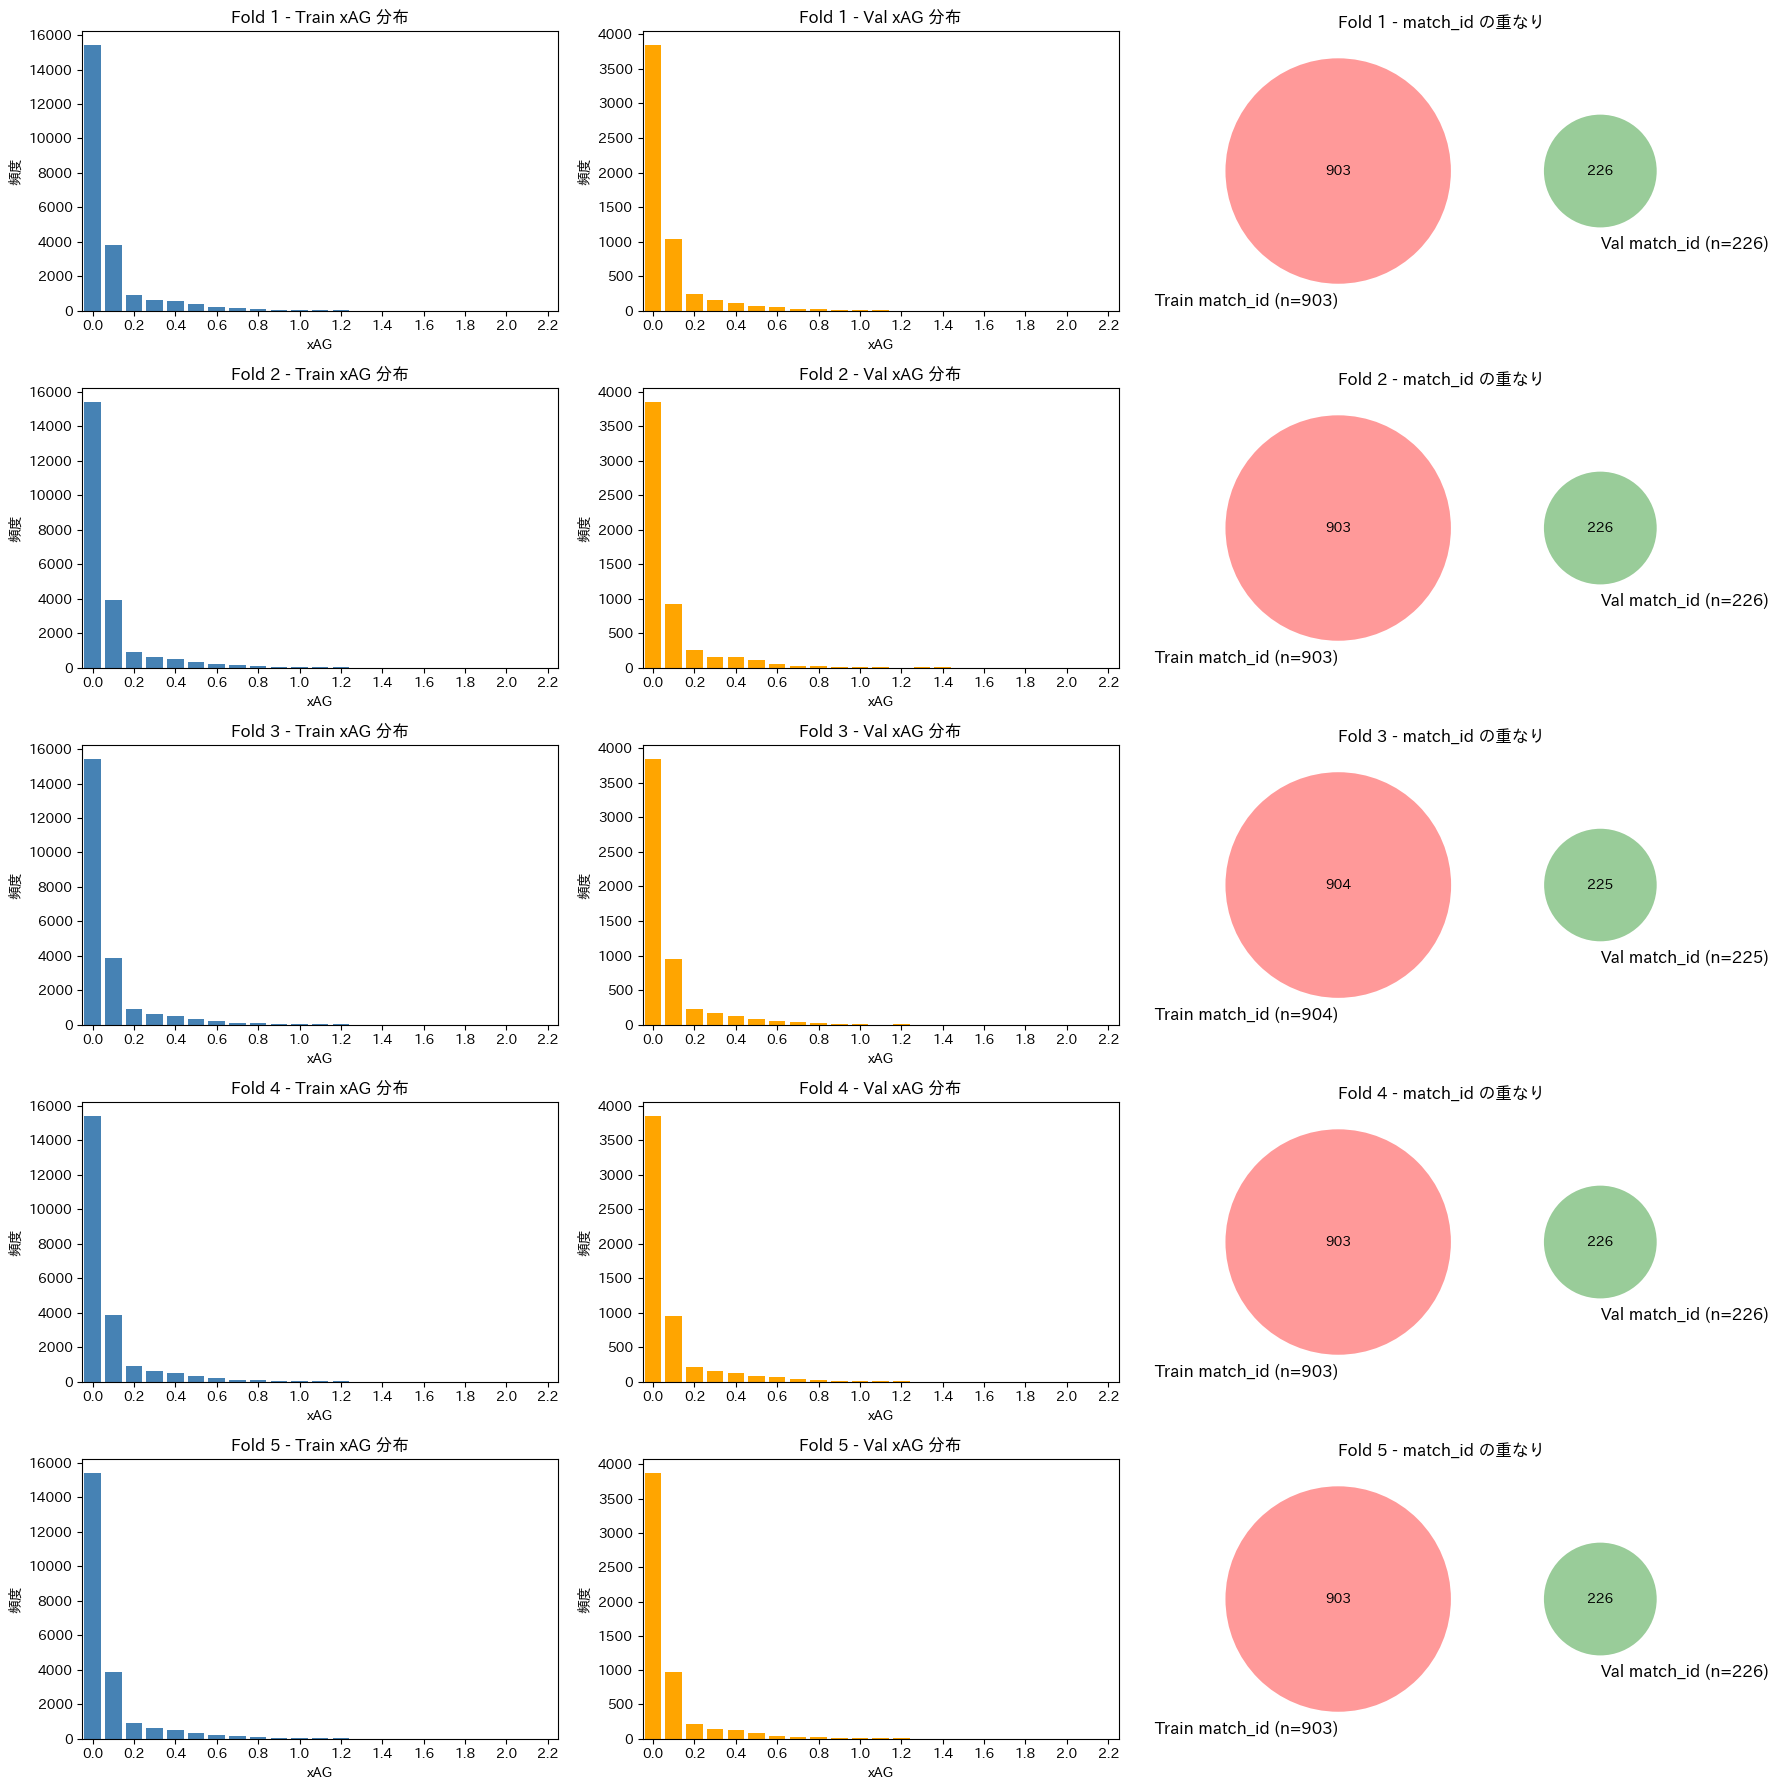

In [23]:
# 5分割のGroupKFoldを設定（match_idでグループ化）
gkf = GroupKFold(n_splits=5)
train_df["fold"] = 0  # 0で初期化

# xAG軸のスケールは共通化して見やすくする
x_min, x_max = train_df["xAG"].min(), train_df["xAG"].max()
xAG_vals = np.arange(x_min, x_max + 0.1, 0.1).round(1)

# 図: 各foldごとに 3カラム（Train分布, Val分布, match_idベン図）
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 18), sharey=False, sharex=False)

for i, (trn_idx, val_idx) in enumerate(gkf.split(train_df, groups=train_df["match_id"])):
    # fold列をセット
    train_df.loc[val_idx, "fold"] = i + 1

    # train/val の xAG 分布を取得（共通スケールにリインデックス）
    trn_counts = (
        train_df.iloc[trn_idx]["xAG"].value_counts().sort_index()
        .reindex(xAG_vals, fill_value=0)
    )
    val_counts = (
        train_df.iloc[val_idx]["xAG"].value_counts().sort_index()
        .reindex(xAG_vals, fill_value=0)
    )

    # 左列: 各foldのtrainデータ分布
    ax_train = axes[i, 0]
    ax_train.bar(trn_counts.index, trn_counts.values, width=0.08, color="steelblue")
    ax_train.set_title(f"Fold {i+1} - Train xAG 分布")
    ax_train.set_xlabel("xAG")
    ax_train.set_ylabel("頻度")

    # 中列: 各foldのvalidationデータ分布
    ax_val = axes[i, 1]
    ax_val.bar(val_counts.index, val_counts.values, width=0.08, color="orange")
    ax_val.set_title(f"Fold {i+1} - Val xAG 分布")
    ax_val.set_xlabel("xAG")
    ax_val.set_ylabel("頻度")

    # 右列: match_idのベン図（Train vs Val）
    ax_venn = axes[i, 2]
    trn_match_ids = set(train_df.iloc[trn_idx]["match_id"])
    val_match_ids = set(train_df.iloc[val_idx]["match_id"])
    v = venn2(
        [trn_match_ids, val_match_ids],
        set_labels=(f"Train match_id (n={len(trn_match_ids)})",
                    f"Val match_id (n={len(val_match_ids)})"),
        ax=ax_venn
    )
    ax_venn.set_title(f"Fold {i+1} - match_id の重なり")

# x軸を共通スケールに揃える（分布図の2カラムに適用）
for i in range(5):
    for j in [0, 1]:
        ax = axes[i, j]
        ax.set_xlim(x_min - 0.05, x_max + 0.05)  # 端を少し余裕持たせる
        ax.set_xticks(xAG_vals[::2])  # ラベルの数を間引き

plt.tight_layout()
plt.show()

In [24]:

print("eΔxTのλ最適化と特徴量集約を実行中...")

import optuna
from optuna.samplers import TPESampler

edxt_feature_cols = []

if xpass_predictions_df.empty:
    print("xPassの対象アクションが存在しないため、eΔxT特徴量は追加されません。")
else:
    xpass_predictions_df = xpass_predictions_df.copy()
    xpass_predictions_df["xt_learned_delta"] = xpass_predictions_df["xt_learned_delta"].fillna(0.0)
    xpass_predictions_df["xt_learned_start"] = xpass_predictions_df["xt_learned_start"].fillna(0.0)
    xpass_predictions_df["success_component"] = xpass_predictions_df["xpass_prob"] * xpass_predictions_df["xt_learned_delta"]
    xpass_predictions_df["fail_component_raw"] = (1.0 - xpass_predictions_df["xpass_prob"]) * xpass_predictions_df["xt_learned_start"]
    xpass_predictions_df["fail_weight"] = (1.0 - xpass_predictions_df["xpass_prob"]).fillna(0.0)

    train_actions = xpass_predictions_df[xpass_predictions_df["is_train_action"]].copy()

    global_start_mean = float(train_actions["xt_learned_start"].mean()) if not train_actions.empty else 0.0
    global_start_std = float(train_actions["xt_learned_start"].std(ddof=0)) if not train_actions.empty else 0.0
    if global_start_std < 1e-6:
        global_start_std = 1.0

    global_start_median = float(train_actions["xt_learned_start"].median()) if not train_actions.empty else 0.0
    global_start_mad = float((train_actions["xt_learned_start"] - global_start_median).abs().median()) if not train_actions.empty else 0.0
    if global_start_mad < 1e-6:
        global_start_mad = 1.0

    group_mean = train_actions.groupby("xpass_action_group")["xt_learned_start"].mean()
    group_std = train_actions.groupby("xpass_action_group")["xt_learned_start"].std(ddof=0)
    group_median = train_actions.groupby("xpass_action_group")["xt_learned_start"].median()
    group_mad = train_actions.groupby("xpass_action_group")["xt_learned_start"].apply(lambda s: (s - s.median()).abs().median())

    xpass_predictions_df["fail_group_mean"] = xpass_predictions_df["xpass_action_group"].map(group_mean).fillna(global_start_mean)
    xpass_predictions_df["fail_group_std"] = xpass_predictions_df["xpass_action_group"].map(group_std).fillna(global_start_std)
    xpass_predictions_df["fail_group_std"] = xpass_predictions_df["fail_group_std"].where(xpass_predictions_df["fail_group_std"] > 1e-6, global_start_std)

    xpass_predictions_df["fail_group_median"] = xpass_predictions_df["xpass_action_group"].map(group_median).fillna(global_start_median)
    xpass_predictions_df["fail_group_mad"] = xpass_predictions_df["xpass_action_group"].map(group_mad).fillna(global_start_mad)
    xpass_predictions_df["fail_group_mad"] = xpass_predictions_df["fail_group_mad"].where(xpass_predictions_df["fail_group_mad"] > 1e-6, global_start_mad)

    pass_groups = {"pass"}
    setpiece_groups = {"corner", "free_kick"}

    xpass_predictions_df["fail_component_scaled"] = 0.0

    pass_mask = xpass_predictions_df["xpass_action_group"].isin(pass_groups)
    if pass_mask.any():
        pass_scale = xpass_predictions_df.loc[pass_mask, "fail_group_mad"]
        pass_base = xpass_predictions_df.loc[pass_mask, "fail_group_median"]
        xpass_predictions_df.loc[pass_mask, "fail_component_scaled"] = (
            xpass_predictions_df.loc[pass_mask, "fail_weight"]
            * (xpass_predictions_df.loc[pass_mask, "xt_learned_start"] - pass_base)
            / pass_scale
        )

    non_pass_mask = ~pass_mask
    if non_pass_mask.any():
        non_pass_scale = xpass_predictions_df.loc[non_pass_mask, "fail_group_std"]
        non_pass_base = xpass_predictions_df.loc[non_pass_mask, "fail_group_mean"]
        xpass_predictions_df.loc[non_pass_mask, "fail_component_scaled"] = (
            xpass_predictions_df.loc[non_pass_mask, "fail_weight"]
            * (xpass_predictions_df.loc[non_pass_mask, "xt_learned_start"] - non_pass_base)
            / non_pass_scale
        )

    train_actions = xpass_predictions_df[xpass_predictions_df["is_train_action"]].copy()
    train_meta = train_df[["match_id", "player_id", "fold", "xAG"]].copy()
    fold_labels = sorted(train_df["fold"].unique())

    def _weighted_rmse_local(y_true, y_pred):
        w_pos = 5.0
        thresh = 0.1
        weights = np.where(y_true >= thresh, w_pos, 1.0)
        return float(np.sqrt(np.mean(weights * (y_true - y_pred) ** 2) + 1e-9))

    aggregated_components = (
        train_actions.groupby(["match_id", "player_id", "xpass_action_group"])
        .agg(
            success_sum=("success_component", "sum"),
            fail_sum_scaled=("fail_component_scaled", "sum"),
            fail_sum_raw=("fail_component_raw", "sum"),
            fail_weight_sum=("fail_weight", "sum"),
            action_count=("success_component", "count"),
        )
        .reset_index()
    )

    lambda_per_type = {}
    lambda_meta = []
    lambda_bounds = {
        "pass": (-0.5, 1.0),
        "cross": (-0.5, 2.0),
        "dribble": (-0.5, 2.0),
        "carry": (-0.5, 2.0),
        "corner": (-1.5, 3.0),
        "free_kick": (-1.5, 3.0),
    }

    for action_group in sorted(xpass_predictions_df["xpass_action_group"].dropna().unique()):
        type_df = aggregated_components[aggregated_components["xpass_action_group"] == action_group].copy()
        type_df = type_df.merge(train_meta, on=["match_id", "player_id"], how="left")
        type_df = type_df.dropna(subset=["xAG", "fold"])

        if type_df.empty:
            lambda_per_type[action_group] = 0.0
            continue

        lam_low, lam_high = lambda_bounds.get(action_group, (-1.0, 2.0))

        def objective(trial):
            lam = trial.suggest_float("lambda", lam_low, lam_high)
            preds = type_df["success_sum"] - lam * type_df["fail_sum_scaled"]
            scores = []
            for fold in fold_labels:
                fold_mask = type_df["fold"] == fold
                if not fold_mask.any():
                    continue
                scores.append(
                    _weighted_rmse_local(
                        type_df.loc[fold_mask, "xAG"].to_numpy(),
                        preds.loc[fold_mask].to_numpy(),
                    )
                )
            return float(np.mean(scores)) if scores else 1.0

        study = optuna.create_study(direction="minimize", sampler=TPESampler(seed=SEED))
        study.optimize(objective, n_trials=35, show_progress_bar=False)
        best_lambda = float(study.best_params["lambda"])
        lambda_per_type[action_group] = best_lambda
        lambda_meta.append(
            {
                "action_type": action_group,
                "lambda": best_lambda,
                "lambda_min": lam_low,
                "lambda_max": lam_high,
                "train_rows": int(type_df.shape[0]),
                "actions_per_player_mean": float(type_df["action_count"].mean()),
                "fail_scaled_mean": float(type_df["fail_sum_scaled"].mean()),
            }
        )

    lambda_meta_df = pd.DataFrame(lambda_meta)
    if not lambda_meta_df.empty:
        display(lambda_meta_df.sort_values("lambda"))
        print("λ分布統計:")
        display(lambda_meta_df["lambda"].describe())

    for action_group, lam_value in lambda_per_type.items():
        type_actions = xpass_predictions_df[xpass_predictions_df["xpass_action_group"] == action_group].copy()
        if type_actions.empty:
            continue

        type_actions["edxt_value_scaled"] = type_actions["success_component"] - lam_value * type_actions["fail_component_scaled"]
        type_actions["edxt_positive_scaled"] = np.clip(type_actions["edxt_value_scaled"], 0.0, None)
        type_actions["edxt_value"] = type_actions["success_component"] - lam_value * type_actions["fail_component_raw"]
        type_actions["edxt_positive"] = np.clip(type_actions["edxt_value"], 0.0, None)

        agg_train = (
            type_actions[type_actions["is_train_action"]]
            .groupby(["match_id", "player_id"])
            .agg(
                edxt_sum=("edxt_value", "sum"),
                edxt_mean=("edxt_value", "mean"),
                edxt_max=("edxt_value", "max"),
                edxt_positive_sum=("edxt_positive", "sum"),
                edxt_positive_mean=("edxt_positive", "mean"),
                edxt_scaled_sum=("edxt_value_scaled", "sum"),
                edxt_scaled_mean=("edxt_value_scaled", "mean"),
                edxt_scaled_max=("edxt_value_scaled", "max"),
                edxt_scaled_positive_sum=("edxt_positive_scaled", "sum"),
                edxt_scaled_positive_mean=("edxt_positive_scaled", "mean"),
                edxt_count=("edxt_value", "count"),
                success_sum=("success_component", "sum"),
                fail_sum_raw=("fail_component_raw", "sum"),
                fail_sum_scaled=("fail_component_scaled", "sum"),
                fail_weight_sum=("fail_weight", "sum"),
            )
            .reset_index()
        )

        agg_test = (
            type_actions[~type_actions["is_train_action"]]
            .groupby(["match_id", "player_id"])
            .agg(
                edxt_sum=("edxt_value", "sum"),
                edxt_mean=("edxt_value", "mean"),
                edxt_max=("edxt_value", "max"),
                edxt_positive_sum=("edxt_positive", "sum"),
                edxt_positive_mean=("edxt_positive", "mean"),
                edxt_scaled_sum=("edxt_value_scaled", "sum"),
                edxt_scaled_mean=("edxt_value_scaled", "mean"),
                edxt_scaled_max=("edxt_value_scaled", "max"),
                edxt_scaled_positive_sum=("edxt_positive_scaled", "sum"),
                edxt_scaled_positive_mean=("edxt_positive_scaled", "mean"),
                edxt_count=("edxt_value", "count"),
                success_sum=("success_component", "sum"),
                fail_sum_raw=("fail_component_raw", "sum"),
                fail_sum_scaled=("fail_component_scaled", "sum"),
                fail_weight_sum=("fail_weight", "sum"),
            )
            .reset_index()
        )

        col_map = {
            "edxt_sum": f"{action_group}_edxt_sum",
            "edxt_mean": f"{action_group}_edxt_mean",
            "edxt_max": f"{action_group}_edxt_max",
            "edxt_positive_sum": f"{action_group}_edxt_positive_sum",
            "edxt_positive_mean": f"{action_group}_edxt_positive_mean",
            "edxt_scaled_sum": f"{action_group}_edxt_scaled_sum",
            "edxt_scaled_mean": f"{action_group}_edxt_scaled_mean",
            "edxt_scaled_max": f"{action_group}_edxt_scaled_max",
            "edxt_scaled_positive_sum": f"{action_group}_edxt_scaled_positive_sum",
            "edxt_scaled_positive_mean": f"{action_group}_edxt_scaled_positive_mean",
            "edxt_count": f"{action_group}_edxt_count",
            "success_sum": f"{action_group}_edxt_success_sum",
            "fail_sum_raw": f"{action_group}_edxt_fail_sum",
            "fail_sum_scaled": f"{action_group}_edxt_fail_scaled_sum",
            "fail_weight_sum": f"{action_group}_fail_weight_sum",
        }

        train_df = train_df.merge(agg_train.rename(columns=col_map), on=["match_id", "player_id"], how="left")
        test_df = test_df.merge(agg_test.rename(columns=col_map), on=["match_id", "player_id"], how="left")

        for new_col in col_map.values():
            if new_col not in train_df.columns:
                train_df[new_col] = 0.0
            if new_col not in test_df.columns:
                test_df[new_col] = 0.0
            train_df[new_col] = train_df[new_col].fillna(0.0)
            test_df[new_col] = test_df[new_col].fillna(0.0)

        edxt_feature_cols.extend(col_map.values())

    openplay_groups = {"pass", "cross", "dribble", "carry"}

    def _sum_columns(df, cols, new_col):
        found = [col for col in cols if col in df.columns]
        if found:
            df[new_col] = df[found].sum(axis=1)
        else:
            df[new_col] = 0.0

    setpiece_scaled_cols = [f"{g}_edxt_scaled_positive_sum" for g in setpiece_groups]
    openplay_scaled_cols = [f"{g}_edxt_scaled_positive_sum" for g in openplay_groups]
    setpiece_raw_cols = [f"{g}_edxt_positive_sum" for g in setpiece_groups]
    openplay_raw_cols = [f"{g}_edxt_positive_sum" for g in openplay_groups]

    for df in (train_df, test_df):
        _sum_columns(df, setpiece_scaled_cols, "setpiece_edxt_scaled_positive_sum")
        _sum_columns(df, openplay_scaled_cols, "openplay_edxt_scaled_positive_sum")
        _sum_columns(df, setpiece_raw_cols, "setpiece_edxt_positive_sum")
        _sum_columns(df, openplay_raw_cols, "openplay_edxt_positive_sum")

        scaled_denom = df["setpiece_edxt_scaled_positive_sum"] + df["openplay_edxt_scaled_positive_sum"]
        raw_denom = df["setpiece_edxt_positive_sum"] + df["openplay_edxt_positive_sum"]

        df["setpiece_edxt_scaled_ratio"] = np.where(scaled_denom > 0, df["setpiece_edxt_scaled_positive_sum"] / scaled_denom, 0.0)
        df["setpiece_edxt_raw_ratio"] = np.where(raw_denom > 0, df["setpiece_edxt_positive_sum"] / raw_denom, 0.0)

    edxt_feature_cols.extend([
        "setpiece_edxt_scaled_positive_sum",
        "openplay_edxt_scaled_positive_sum",
        "setpiece_edxt_positive_sum",
        "openplay_edxt_positive_sum",
        "setpiece_edxt_scaled_ratio",
        "setpiece_edxt_raw_ratio",
    ])

    edxt_feature_cols = sorted(dict.fromkeys(edxt_feature_cols))


eΔxTのλ最適化と特徴量集約を実行中...


[I 2025-10-03 08:01:33,445] A new study created in memory with name: no-name-8c47bb7d-b81b-4c94-a2c5-80f2440fedde
[I 2025-10-03 08:01:33,447] Trial 0 finished with value: 0.7065305210862173 and parameters: {'lambda': 0.18543053481313132}. Best is trial 0 with value: 0.7065305210862173.
[I 2025-10-03 08:01:33,448] Trial 1 finished with value: 4.331770552652218 and parameters: {'lambda': 2.7782143788446225}. Best is trial 0 with value: 0.7065305210862173.
[I 2025-10-03 08:01:33,449] Trial 2 finished with value: 2.909040665627385 and parameters: {'lambda': 1.7939727381513229}. Best is trial 0 with value: 0.7065305210862173.
[I 2025-10-03 08:01:33,451] Trial 3 finished with value: 2.0607785979422935 and parameters: {'lambda': 1.1939631788866647}. Best is trial 0 with value: 0.7065305210862173.
[I 2025-10-03 08:01:33,452] Trial 4 finished with value: 1.4864588800950969 and parameters: {'lambda': -0.7979161180090357}. Best is trial 0 with value: 0.7065305210862173.
[I 2025-10-03 08:01:33,453

,action_type,lambda,lambda_min,lambda_max,train_rows,actions_per_player_mean,fail_scaled_mean
2,dribble,-0.031776,-0.5,2.0,24546,4.929479,0.016210
0,corner,-0.018068,-1.5,3.0,3569,2.384982,0.032627
3,free_kick,-0.018068,-1.5,3.0,2901,1.653568,0.029356
4,pass,-0.006023,-0.5,1.0,27405,31.712461,4.705270
1,cross,0.015409,-0.5,2.0,13917,2.504635,0.054579


λ分布統計:


count    5.000000
mean    -0.011705
std      0.017686
min     -0.031776
25%     -0.018068
50%     -0.018068
75%     -0.006023
max      0.015409
Name: lambda, dtype: float64

In [25]:

print("チーム文脈特徴量を追加しています...")

team_context_feature_cols = []
team_base_candidates = [
    col
    for col in train_df.columns
    if col.startswith("xt_learned_") or col.startswith("possession_xt_") or col.endswith("_edxt_sum")
]
team_base_columns = [col for col in team_base_candidates if np.issubdtype(train_df[col].dtype, np.number)]

if team_base_columns:
    for df in (train_df, test_df):
        for col in team_base_columns:
            team_sum = df.groupby(["match_id", "Squad"])[col].transform("sum")
            sum_col = f"{col}_team_sum"
            share_col = f"{col}_team_share"
            lopo_col = f"{col}_team_lopo"
            df[sum_col] = team_sum
            df[share_col] = np.where(team_sum != 0, df[col] / team_sum, 0.0)
            df[lopo_col] = team_sum - df[col]
            df[sum_col] = df[sum_col].fillna(0.0)
            df[share_col] = df[share_col].fillna(0.0)
            df[lopo_col] = df[lopo_col].fillna(0.0)
            if df is train_df:
                team_context_feature_cols.extend([sum_col, share_col, lopo_col])

    team_context_feature_cols = sorted(dict.fromkeys(team_context_feature_cols))
else:
    team_context_feature_cols = []

チーム文脈特徴量を追加しています...


In [26]:

print("リーグ別ゲーティング特徴を作成しています...")

comp_interaction_feature_cols = []
comp_cross_base_features = [
    col
    for col in [
        "xt_learned_delta_sum",
        "xt_learned_positive_delta_sum",
        "possession_xt_positive_sum",
        "possession_xt_delta_sum",
        "possession_speed_ground_mean",
    ]
    if col in train_df.columns
]

if comp_cross_base_features:
    comp_dummy_train = pd.get_dummies(train_df["Comp"].astype(str), prefix="comp_gate", dtype=float)
    comp_dummy_test = pd.get_dummies(test_df["Comp"].astype(str), prefix="comp_gate", dtype=float)
    comp_dummy_train, comp_dummy_test = comp_dummy_train.align(comp_dummy_test, join="outer", axis=1, fill_value=0.0)
    comp_dummy_test = comp_dummy_test[comp_dummy_train.columns]

    train_base = train_df[comp_cross_base_features].fillna(0.0)
    test_base = test_df[comp_cross_base_features].fillna(0.0)

    for base_col in comp_cross_base_features:
        train_values = train_base[base_col].to_numpy()
        test_values = test_base[base_col].to_numpy()
        for comp_col in comp_dummy_train.columns:
            feat_name = f"{base_col}__{comp_col}"
            train_df[feat_name] = train_values * comp_dummy_train[comp_col].to_numpy()
            test_df[feat_name] = test_values * comp_dummy_test[comp_col].to_numpy()
            comp_interaction_feature_cols.append(feat_name)

    comp_interaction_feature_cols = sorted(dict.fromkeys(comp_interaction_feature_cols))
else:
    comp_interaction_feature_cols = []

リーグ別ゲーティング特徴を作成しています...


## 特徴量の統合

作成した全ての特徴量を統合し、train/testデータにマージします。

In [27]:
# 応用特徴量をtrain/testへマージ
train_df = (
    train_df
    .merge(success_rates, on=['match_id', 'player_id'], how='left')
    .merge(zone_actions, on=['match_id', 'player_id'], how='left')
    .merge(per_minute_features, on=['match_id', 'player_id'], how='left')
    .merge(offense_defense_balance, on=['match_id', 'player_id'], how='left')
    .merge(pass_leads_to_shot, on=['match_id', 'player_id'], how='left')
    .merge(progressive_features, on=['match_id', 'player_id'], how='left')
)

train_df['pass_leads_to_shot'] = train_df['pass_leads_to_shot'].fillna(0)

progressive_cols = [col for col in progressive_features.columns if col not in ['match_id', 'player_id']]
for col in progressive_cols:
    train_df[col] = train_df[col].fillna(0.0)


test_df = (
    test_df
    .merge(success_rates, on=['match_id', 'player_id'], how='left')
    .merge(zone_actions, on=['match_id', 'player_id'], how='left')
    .merge(per_minute_features, on=['match_id', 'player_id'], how='left')
    .merge(offense_defense_balance, on=['match_id', 'player_id'], how='left')
    .merge(pass_leads_to_shot, on=['match_id', 'player_id'], how='left')
    .merge(progressive_features, on=['match_id', 'player_id'], how='left')
)

test_df['pass_leads_to_shot'] = test_df['pass_leads_to_shot'].fillna(0)
for col in progressive_cols:
    test_df[col] = test_df[col].fillna(0.0)

print(f"マージ後のtrainデータshape: {train_df.shape}")
print(f"マージ後のtestデータshape: {test_df.shape}")

マージ後のtrainデータshape: (27870, 281)
マージ後のtestデータshape: (12798, 279)


## クロスバリデーション分割

初回のbaselineでは、全データをランダムに分割するKFoldを用いましたが、今回はデータ特性に合わせた別の分割方法を行います。

EDAで確認したように、今回はtrainデータとtestデータについては、match_idの重なりはありません。
すなわち、testデータを予測するときには、これまで見たことのない試合のデータに対して予測をする必要があります。
この状況をtrainデータ内部でのCross Validationでもなるべく再現することによって、実際のタスクに近い状況で正しい評価が可能になります。

ここでは、GroupKFoldを用いて、trainデータをmatch_idが被らないように5分割します。こうすることで、各foldでのtrainデータとvalidデータのmatch_idが重ならなくなります。


## モデル学習用データ準備

In [28]:
# ターゲットエンコーディング特徴量の作成
print("ターゲットエンコーディング特徴量を作成中...")

# Squad×Opponentの交互作用特徴を作成
train_df["Squad_x_Opponent"] = train_df["Squad"].astype(str) + "_vs_" + train_df["Opponent"].astype(str)
test_df["Squad_x_Opponent"] = test_df["Squad"].astype(str) + "_vs_" + test_df["Opponent"].astype(str)

target_encoding_cols = ["player_id", "Squad", "Opponent", "Squad_x_Opponent"]
global_mean = train_df["xAG"].mean()
smoothing = 10.0
fold_labels = sorted(train_df["fold"].unique())

for col in target_encoding_cols:
    enc_col = f"{col}_target_enc"
    train_df[enc_col] = np.nan

    for fold in fold_labels:
        trn = train_df[train_df["fold"] != fold]
        val_mask = train_df["fold"] == fold

        stats = trn.groupby(col)["xAG"].agg(["sum", "count"])
        stats["encoding"] = (stats["sum"] + global_mean * smoothing) / (stats["count"] + smoothing)

        train_df.loc[val_mask, enc_col] = train_df.loc[val_mask, col].map(stats["encoding"]).fillna(global_mean)

    overall_stats = train_df.groupby(col)["xAG"].agg(["sum", "count"])
    overall_stats["encoding"] = (overall_stats["sum"] + global_mean * smoothing) / (overall_stats["count"] + smoothing)

    test_df[enc_col] = test_df[col].map(overall_stats["encoding"]).fillna(global_mean)

    missing_train = train_df[enc_col].isna().sum()
    missing_test = test_df[enc_col].isna().sum()

    if missing_train > 0:
        train_df.loc[train_df[enc_col].isna(), enc_col] = global_mean
    if missing_test > 0:
        test_df.loc[test_df[enc_col].isna(), enc_col] = global_mean

    print(f"  {col}: train missing {int(missing_train)}, test missing {int(missing_test)}")

ターゲットエンコーディング特徴量を作成中...
  player_id: train missing 0, test missing 0
  Squad: train missing 0, test missing 0
  Opponent: train missing 0, test missing 0
  Squad_x_Opponent: train missing 0, test missing 0


In [29]:

# 各特徴量グループの定義
base_features = ["age", "action_count", "avg_x", "avg_y", "minutes_played", "goal_count"]
categorical_features = ["Comp", "Squad", "Venue"]
action_type_features = [col for col in train_df.columns if (col.startswith('type_')) and (col.endswith('_count'))]
success_rate_features = [
    col for col in train_df.columns
    if col.endswith('_success_rate') and not col.startswith('progressive_')
]
zone_features = [col for col in train_df.columns if col.startswith('zone_')]
per_minute_features = [col for col in train_df.columns if col.endswith('_per_minute')]
ad_balance_features = ['type_offensive_actions', 'type_defensive_actions', 'type_offensive_action_ratio']
sequencial_features = ['pass_leads_to_shot']
progressive_feature_cols = [
    col for col in train_df.columns
    if col.startswith('progressive_')
    or col in ['deep_completion_count', 'final_third_entry_count', 'penalty_area_entry_count']
]
xt_cols = [col for col in train_df.columns if col.startswith('xt_')]
target_encoding_features = [f"{col}_target_enc" for col in ["player_id", "Squad", "Opponent", "Squad_x_Opponent"]]
possession_features = [col for col in train_df.columns if col.startswith('possession_')]
pass_network_features = [col for col in train_df.columns if col.startswith('pass_net_')]
edxt_features = sorted(globals().get('edxt_feature_cols', []))
team_context_features = sorted(globals().get('team_context_feature_cols', []))
comp_interaction_features = sorted(globals().get('comp_interaction_feature_cols', []))

all_features = (
    base_features
    + categorical_features
    + action_type_features
    + success_rate_features
    + zone_features
    + per_minute_features
    + ad_balance_features
    + sequencial_features
    + progressive_feature_cols
    + xt_cols
    + target_encoding_features
    + possession_features
    + pass_network_features
    + edxt_features
    + team_context_features
    + comp_interaction_features
)

all_features = list(dict.fromkeys(all_features))

# カテゴリカル変数については、列の型を「category」に変更しておく
for col in categorical_features:
    train_df[col] = train_df[col].astype("category")
    test_df[col] = test_df[col].astype("category")

print(f"  - 使用する特徴量数: {len(all_features)}個")
print(f"  - 基本特徴量: {len(base_features)}個")
print(f"  - カテゴリカル特徴量: {len(categorical_features)}個")
print(f"  - アクション特徴量(type_*_count): {len(action_type_features)}個")
print(f"  - 成功率系: {len(success_rate_features)}個")
print(f"  - ゾーン系: {len(zone_features)}個")
print(f"  - per_minute系: {len(per_minute_features)}個")
print(f"  - 攻守バランス系: {len(ad_balance_features)}個")
print(f"  - 時系列系: {len(sequencial_features)}個")
print(f"  - プログレッシブ系: {len(progressive_feature_cols)}個")
print(f"  - xT系: {len(xt_cols)}個")
print(f"  - ターゲットエンコーディング系: {len(target_encoding_features)}個")
print(f"  - ポゼッション進攻系: {len(possession_features)}個")
print(f"  - パスネットワーク系: {len(pass_network_features)}個")
print(f"  - eΔxT系: {len(edxt_features)}個")
print(f"  - チーム文脈系: {len(team_context_features)}個")
print(f"  - リーグ相互作用系: {len(comp_interaction_features)}個")

  - 使用する特徴量数: 273個
  - 基本特徴量: 6個
  - カテゴリカル特徴量: 3個
  - アクション特徴量(type_*_count): 19個
  - 成功率系: 7個
  - ゾーン系: 6個
  - per_minute系: 21個
  - 攻守バランス系: 3個
  - 時系列系: 1個
  - プログレッシブ系: 13個
  - xT系: 50個
  - ターゲットエンコーディング系: 4個
  - ポゼッション進攻系: 37個
  - パスネットワーク系: 8個
  - eΔxT系: 81個
  - チーム文脈系: 54個
  - リーグ相互作用系: 25個


In [30]:
# モデル学習用データの作成
X_train = train_df[all_features + ["fold"]]
y_train = train_df["xAG"]
X_test = test_df[all_features]

print(f"\nモデル学習用データ形状: X_train {X_train.shape}, y_train {y_train.shape}, X_test {X_test.shape}")


モデル学習用データ形状: X_train (27870, 274), y_train (27870,), X_test (12798, 273)


## モデル学習（LightGBM）

In [31]:
# コンペの評価指標に合わせた目的関数/評価関数の定義
def weighted_rmse(y_true, y_pred):
    """
    重み付きRMSE評価関数
    コンペの評価指標に合わせて実装
    """
    w_pos = 5.0
    thresh = 0.1

    # Calculate weighted squared errors
    weights = np.where(y_true >= thresh, w_pos, 1.0)
    squared_errors = (y_true - y_pred) ** 2
    weighted_squared_errors = weights * squared_errors

    # Calculate weighted RMSE with small epsilon for numerical stability
    pw_rmse = np.sqrt(np.mean(weighted_squared_errors) + 1e-9)

    return float(pw_rmse)

def weighted_rmse_feval(y_pred, dtrain):
    """
    LightGBM用の重み付きRMSE評価関数
    """
    y_true = dtrain.get_label()
    weighted_rmse_value = weighted_rmse(y_true, y_pred)
    return "weighted_rmse", weighted_rmse_value, False

def weighted_rmse_obj(y_pred, dtrain):
    """
    LightGBM用の重み付きRMSE目的関数
    """
    w_pos = 5.0
    thresh = 0.1

    y_true = dtrain.get_label()
    weights = np.where(y_true >= thresh, w_pos, 1.0)

    # 勾配とヘッセ行列の計算
    grad = -2 * weights * (y_true - y_pred)
    hess = 2 * weights

    return grad, hess

特徴量の数も増えており、ハイパーパラメータは探索してみないと分かりません。

ここでは、より効率的に良さそうなパラメータを見つけられるOptunaを用いて最適化を行います。
Optunaは探索空間から試行回数ごとに候補を提案し、良かった試行の情報を活かしながら次の探索に反映させるベイズ的最適化アルゴリズム（TPEサンプラー）を利用できるため、総当たりのGridSearchよりも少ない試行で良い結果に辿り着きやすいのがメリットです。
（参考: https://zenn.dev/robes/articles/d53ff6d665650f ）

In [32]:
import optuna
from optuna.samplers import TPESampler

# Optunaで最適化しないベースパラメータ
base_params = {
    "objective": weighted_rmse_obj,
    "boosting_type": "gbdt",
    "random_state": SEED,
    "verbosity": -1,
    "force_col_wise": True,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "feature_fraction": 0.8,
}

# Optunaで探索するハイパーパラメータの概要
optuna_search_space = {
    "num_leaves": (10, 64),
    "learning_rate": (0.01, 0.1),
    "min_child_samples": (10, 50),
}

print("Optuna用ハイパーパラメータ設定完了")
print(f"探索対象パラメータ: {list(optuna_search_space.keys())}")

Optuna用ハイパーパラメータ設定完了
探索対象パラメータ: ['num_leaves', 'learning_rate', 'min_child_samples']


In [33]:
try:
    base_dir = Path(__file__).resolve().parent
except NameError:  # __file__ はノートブック実行時には定義されない
    base_dir = Path.cwd()

log_dir = base_dir / "logs"
log_dir.mkdir(parents=True, exist_ok=True)


def save_training_run(
    cv_scores,
    oof_score,
    optuna_summary,
    best_params,
    log_directory: Path,
    log_prefix: str = "host_baseline_002",
):
    """Persist CV metrics to reusable JSON/text logs."""

    timestamp = datetime.now().astimezone().isoformat(timespec="seconds")

    metrics_payload = {
        "run_timestamp": timestamp,
        "cv": {
            "scores": [float(score) for score in cv_scores],
            "mean": float(np.mean(cv_scores)),
            "std": float(np.std(cv_scores)),
        },
        "per_fold": {f"fold_{idx + 1}": float(score) for idx, score in enumerate(cv_scores)},
        "oof_rmse": float(oof_score),
        "optuna": optuna_summary,
        "best_params": {key: (float(val) if isinstance(val, (np.floating, np.integer)) else val)
                         for key, val in best_params.items()},
    }

    metrics_path = log_directory / f"{log_prefix}_metrics.json"
    metrics_path.write_text(json.dumps(metrics_payload, ensure_ascii=False, indent=2), encoding="utf-8")

    log_lines = [
        f"[{timestamp}] {log_prefix}",
        f"  CV mean: {metrics_payload['cv']['mean']:.4f}",
        f"  CV std: {metrics_payload['cv']['std']:.4f}",
        f"  OOF RMSE: {metrics_payload['oof_rmse']:.4f}",
    ]
    for idx, score in enumerate(cv_scores, start=1):
        log_lines.append(f"  Fold {idx}: {score:.4f}")

    log_lines.append(
        "  Optuna best trial: "
        f"{optuna_summary['best_trial_number']} (CV mean {optuna_summary['best_cv_value']:.6f}, "
        f"fold1 RMSE {optuna_summary['fold1_val_rmse']:.6f})"
    )

    log_path = log_directory / f"{log_prefix}_training.log"
    with log_path.open("a", encoding="utf-8") as fp:
        fp.write("\n".join(log_lines) + "\n")


# Optunaによるハイパーパラメータチューニング
print("Optunaによるチューニングを開始します...")

# Fold 1を検証用に確保（後でスコア確認に利用）
trn_mask = train_df["fold"] != 1
val_mask = train_df["fold"] == 1

X_tr = train_df.loc[trn_mask, all_features].copy()
X_val = train_df.loc[val_mask, all_features].copy()
y_tr = y_train.loc[trn_mask].copy()
y_val = y_train.loc[val_mask].copy()

def objective(trial):
    params = base_params.copy()
    params.update({
        "num_leaves": trial.suggest_int("num_leaves", *optuna_search_space["num_leaves"]),
        "learning_rate": trial.suggest_float("learning_rate", *optuna_search_space["learning_rate"], log=True),
        "min_child_samples": trial.suggest_int("min_child_samples", *optuna_search_space["min_child_samples"]),
    })

    cv_scores = []
    for fold in range(1, 4):  # 計算量を抑えるためFold1~3でCV
        trn_mask_cv = train_df["fold"] != fold
        val_mask_cv = train_df["fold"] == fold

        X_tr_cv = train_df.loc[trn_mask_cv, all_features].copy()
        X_val_cv = train_df.loc[val_mask_cv, all_features].copy()
        y_tr_cv = y_train.loc[trn_mask_cv].copy()
        y_val_cv = y_train.loc[val_mask_cv].copy()

        train_data = lgb.Dataset(X_tr_cv, label=y_tr_cv)
        val_data = lgb.Dataset(X_val_cv, label=y_val_cv)

        model = lgb.train(
            params,
            train_data,
            valid_sets=[val_data],
            feval=weighted_rmse_feval,
            num_boost_round=1000,
            callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)],
        )

        preds = model.predict(X_val_cv, num_iteration=model.best_iteration)
        cv_scores.append(weighted_rmse(y_val_cv, preds))

    return float(np.mean(cv_scores))

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="minimize", sampler=TPESampler(seed=SEED))
study.optimize(objective, n_trials=30, show_progress_bar=True)

best_params = study.best_trial.params.copy()
best_lgbm_params = base_params.copy()
best_lgbm_params.update(best_params)

# Fold1でのスコアを再確認
train_data = lgb.Dataset(X_tr, label=y_tr)
val_data = lgb.Dataset(X_val, label=y_val)
best_model = lgb.train(
    best_lgbm_params,
    train_data,
    valid_sets=[train_data, val_data],
    valid_names=["train", "val"],
    feval=weighted_rmse_feval,
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)],
)

val_pred = best_model.predict(X_val, num_iteration=best_model.best_iteration)
val_score = weighted_rmse(y_val, val_pred)

print("=== Optunaチューニング結果 ===")
print(f"最良Trial番号: {study.best_trial.number}")
print(f"平均CV RMSE: {study.best_value:.6f}")
print(f"Fold1 Validation RMSE: {val_score:.6f}")
print("最適化されたパラメータ:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

Optunaによるチューニングを開始します...


  0%|          | 0/30 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[89]	valid_0's weighted_rmse: 0.237985
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[54]	valid_0's weighted_rmse: 0.259637
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[94]	valid_0's weighted_rmse: 0.244722
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[916]	valid_0's weighted_rmse: 0.236741
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[522]	valid_0's weighted_rmse: 0.256028
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[589]	valid_0's weighted_rmse: 0.241915
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[373]	valid_0's weighted_rmse: 0.238418
Training until validation score

In [ ]:
# 最適化されたパラメータでの5-Fold Cross Validation
print("最適化されたパラメータでの5-Fold Cross Validationを開始...")

# 単調性制約の設定
# xAGと単調増加関係にある特徴量を選定
monotone_increase_features = [
    # プログレッシブ系（攻撃的な前進プレー → xAG増加）
    'progressive_pass_count',
    'progressive_pass_success',
    'progressive_pass_distance_total',
    'progressive_pass_distance_mean',
    'progressive_carry_count',
    'progressive_carry_success',
    'progressive_carry_distance_total',
    'progressive_carry_distance_mean',
    'deep_completion_count',  # ディープゾーン到達数
    'final_third_entry_count',  # ファイナルサード進入数
    'penalty_area_entry_count',  # ペナルティエリア進入数

    # シュート・ゴール系（創造性の指標）
    'goal_count',  # ゴール数
    'pass_leads_to_shot',  # パス→ショットの連鎖

    # 攻撃的ゾーン活動（前線でのプレー → xAG増加）
    'zone_attacking_actions',  # 攻撃ゾーンでのアクション数
    'zone_attacking_actions_ratio',  # 攻撃ゾーン比率

    # 攻撃的バランス
    'type_offensive_actions',  # 攻撃アクション数
    'type_offensive_action_ratio',  # 攻撃アクション比率
]

missing_monotone_features = [feat for feat in monotone_increase_features if feat not in all_features]
if missing_monotone_features:
    print("単調性制約対象として指定したものの、特徴量一覧に存在しない列があります:")
    for feat in missing_monotone_features:
        print(f"  - {feat}")

applied_monotone_features = [feat for feat in monotone_increase_features if feat in all_features]

# all_features内での各特徴量のインデックスを取得し、単調性ベクトルを構築
monotone_constraints = [0] * len(all_features)  # デフォルトは制約なし(0)
for feat in applied_monotone_features:
    idx = all_features.index(feat)
    monotone_constraints[idx] = 1  # 単調増加制約

print(f"\n単調性制約を適用: {len(applied_monotone_features)}個の特徴量")
print("単調増加制約を適用した特徴量:")
for feat in applied_monotone_features:
    print(f"  - {feat}")

# LightGBM学習のパラメータを設定（Optunaで最適化されたパラメータを使用）
lgbm_params = {
    "objective": weighted_rmse_obj,
    "boosting_type": "gbdt",
    "random_state": SEED,
    "verbosity": -1,
    "force_col_wise": True,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "feature_fraction": 0.8,
    "monotone_constraints": monotone_constraints,  # 単調性制約を追加
    "monotone_constraints_method": "advanced",  # advanced methodを使用
}

# Optunaの最適パラメータをマージ
lgbm_params.update(best_params)

print(f"\n使用するパラメータ: {lgbm_params}")

# 5-Foldでのモデル学習（最適化されたパラメータ使用）
oof_preds = np.zeros(len(X_train))
cv_scores = []
models = []
feature_importance = pd.DataFrame()

# Training the models on the entire training data
for fold in range(5):
    print(f"=== Fold {fold + 1} ===")

    # データ分割
    trn_mask = train_df["fold"] != fold+1
    val_mask = train_df["fold"] == fold+1

    X_tr = train_df.loc[trn_mask, all_features].copy()
    X_val = train_df.loc[val_mask, all_features].copy()
    y_tr = y_train.loc[trn_mask].copy()
    y_val = y_train.loc[val_mask].copy()

    # LightGBMデータセット作成
    train_data = lgb.Dataset(X_tr, label=y_tr)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    # モデル学習（最適パラメータ使用）
    model = lgb.train(
        lgbm_params,
        train_data,
        valid_sets=[train_data, val_data],
        valid_names=["train", "val"],
        feval=weighted_rmse_feval,
        num_boost_round=1000,
        callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)]
    )

    # validationデータに対する予測、スコア算出
    y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
    oof_preds[val_mask] = y_pred_val
    score = weighted_rmse(y_val, y_pred_val)
    cv_scores.append(score)
    models.append(model)  # このfoldのモデルをmodelsに格納

    print(f"Fold {fold + 1} RMSE: {score:.4f}")

    # 特徴量重要度算出
    fold_importance = pd.DataFrame({
        "feature": all_features,
        "importance": model.feature_importance(importance_type="gain"),
        "fold": fold + 1
    })
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

cv_mean = float(np.mean(cv_scores))
cv_std = float(np.std(cv_scores))

print("=== Cross Validation Results (Optimized Parameters) ===")
print(f"CV RMSE: {cv_mean:.4f} (+/- {cv_std * 2:.4f})")
for i, score in enumerate(cv_scores):
    print(f"Fold {i + 1}: {score:.4f}")

# OOF予測のスコア算出
oof_score = weighted_rmse(y_train, oof_preds)
print(f"OOF RMSE: {oof_score:.4f}")

optuna_summary = {
    "best_trial_number": int(study.best_trial.number),
    "best_cv_value": float(study.best_value),
    "fold1_val_rmse": float(val_score),
}

save_training_run(
    cv_scores=cv_scores,
    oof_score=oof_score,
    optuna_summary=optuna_summary,
    best_params=best_params,
    log_directory=log_dir,
)

print(f"メトリクスを保存しました: {log_dir / 'host_baseline_002_metrics.json'}")
print(f"ログを追記しました: {log_dir / 'host_baseline_002_training.log'}")

最適化されたパラメータでの5-Fold Cross Validationを開始...

単調性制約を適用: 17個の特徴量
単調増加制約を適用した特徴量:
  - progressive_pass_count
  - progressive_pass_success
  - progressive_pass_distance_total
  - progressive_pass_distance_mean
  - progressive_carry_count
  - progressive_carry_success
  - progressive_carry_distance_total
  - progressive_carry_distance_mean
  - deep_completion_count
  - final_third_entry_count
  - penalty_area_entry_count
  - goal_count
  - pass_leads_to_shot
  - zone_attacking_actions
  - zone_attacking_actions_ratio
  - type_offensive_actions
  - type_offensive_action_ratio

使用するパラメータ: {'objective': <function weighted_rmse_obj at 0xffff2bfff2e0>, 'boosting_type': 'gbdt', 'random_state': 42, 'verbosity': -1, 'force_col_wise': True, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8, 'monotone_constraints': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## テストデータに対する推論

In [ ]:
# アンサンブル予測（5モデルの平均） on Test Data
test_preds = np.zeros(len(X_test))

for model in models:
    pred = model.predict(X_test, num_iteration=model.best_iteration)
    test_preds += pred

test_preds /= len(models)


print(f"\n=== Test Set Predictions ===")
print(f"予測xAG範囲: {test_preds.min():.3f} 〜 {test_preds.max():.3f}")

# test_dfに予測結果を追加
test_df['predicted_xAG'] = test_preds

## 予測結果の分析

In [ ]:
# 特徴量重要度の平均計算
feature_importance_mean = feature_importance.groupby('feature')['importance'].agg(['mean', 'std']).reset_index()
feature_importance_mean = feature_importance_mean.sort_values('mean', ascending=False)

# 可視化
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance_mean.head(15), x='mean', y='feature')
plt.title('Top 15 Feature Importance (Weighted RMSE Baseline xAG Model)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print("特徴量重要度 Top 10:")
print(feature_importance_mean.head(10))

In [ ]:
# train, test予測値の分布を可視化
plt.figure(figsize=(8, 6))
sns.histplot(oof_preds, stat='density', kde=True, alpha=0.2, label='OOF予測', linewidth=0)
sns.histplot(test_preds, stat='density', kde=True, alpha=0.2, label='Test予測', linewidth=0)

# train正解値の分布を可視化
vc = y_train.value_counts().sort_index()
heights = vc / vc.sum() / 0.1 # 棒グラフの高さをdensity に合わせる
plt.bar(vc.index, heights, width=0.03, alpha=0.6, label='OOF正解', align='center')

plt.xlabel('xAG')
plt.ylabel('密度')
plt.xlim(0, 1)
plt.title('xAG予測値の分布（OOF予測 vs Test予測 vs OOF正解）')
plt.legend()
plt.tight_layout()
plt.show()

正解が0.0のデータの重み付けが小さいため、全体的に正の値を予想する傾向が見られる。

## 提出ファイル作成

In [ ]:
# 提出用ファイルにtestデータに対する予測値を格納
submission_df["xAG"] = test_preds
submission_df.to_csv(f"{base_path}/host_baseline_0017_submissions.csv", index=False)